In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
PATH_TO_PROJECT = '/content/drive/My Drive/Serious/'
# path to conll class as well as to conll data
PATH_TO_CONLL = PATH_TO_PROJECT + 'coNLL/'
PATH_TO_TAG2IDX = PATH_TO_CONLL + 'tag2idx.json'
PATH_TO_ONE_TAG2IDX = PATH_TO_CONLL + 'one_tag2idx.json'
PATH_TO_CHECKPOINT = '/content/drive/My Drive/models/'
PATH_TO_NEW_CHECKPOINT = PATH_TO_CHECKPOINT+'New_results/'

### Intall requirements

In [3]:
!pip install -r '/content/drive/My Drive/Serious/requirements.txt'

     |████████████████████████████████| 1.9MB 18.1MB/s 
     |████████████████████████████████| 604kB 51.5MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
     |████████████████████████████████| 776.8MB 21kB/s 
     |████████████████████████████████| 3.3MB 45.7MB/s 
     |████████████████████████████████| 901kB 49.9MB/s 
     |████████████████████████████████| 122kB 61.8MB/s 
     |████████████████████████████████| 2.1MB 43.1MB/s 
     |████████████████████████████████| 1.2MB 47.1MB/s 
     |████████████████████████████████| 266kB 43.9MB/s 
     |████████████████████████████████| 133kB 59.5MB/s 
     |████████████████████████████████| 163kB 59.0MB/s 
     |████████████████████████████████| 102kB 14.0MB/s 
     |████████████████████████████████| 133kB 58.9MB/s 
     |████████████████████████████████| 7.4MB 43.2MB/s 
     |████████████████████████████████| 81kB 12.2MB/s 
     |████████████████████████████████| 71kB 11.7MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-

### Loading coNLL and my modules

In [4]:
import sys
sys.path.append(PATH_TO_PROJECT)
sys.path.append(PATH_TO_CONLL)

from importlib import reload
import conll as co

import data_loaders as dalo
import model_utils as mu

from bert_config import *
from elmo_config import *

In [5]:
conll = co.CoNLL(PATH_TO_CONLL)

In [6]:
# splitting raw data to sentences and labels
for typ in conll.types:
    conll.split_text_label(typ)

# define set of all labels
conll.create_set_of_labels()

for typ in conll.types:
    # for multiple heads of CRF layer
    conll.create_one_labeled_data(typ)

    # creating one_tag2idx dictionary
    conll.create_one_tag2idx(PATH_TO_ONE_TAG2IDX)
    conll.create_idx2one_tag()

In [7]:
# dict of tag2idx mapping for each CRF-head (one head responsible for 'LOC' etc.)
conll.one_tag2idx

{'LOC': {'B-LOC': 0, 'I-LOC': 3, 'O': 2, 'PAD': 1},
 'MISC': {'B-MISC': 0, 'I-MISC': 3, 'O': 2, 'PAD': 1},
 'ORG': {'B-ORG': 2, 'I-ORG': 3, 'O': 1, 'PAD': 0},
 'PER': {'B-PER': 2, 'I-PER': 0, 'O': 3, 'PAD': 1}}

In [ ]:
print(f"sen example: {conll.sentences['train'][0]}")
print(f"tags example: {conll.labels['train'][0]}")
print(f"tags example with only 'ORG' tag: {conll.one_tag_dict['train']['ORG'][0]}")
print(f"tags for CRF tags has labels: {conll.one_tag_dict['train'].keys()}")

sen example: ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
tags example: ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']
tags example with only 'ORG' tag: ['B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
tags for CRF tags has labels: dict_keys(['PER', 'LOC', 'ORG', 'MISC'])


### Importing external packages

In [8]:
import numpy as np
import torch
from torch import nn
from torch.optim import AdamW
from transformers import BertTokenizer, BertModel
from transformers import BertForTokenClassification
from allennlp.modules.elmo import Elmo, batch_to_ids

from torchcrf import CRF

from sklearn.model_selection import KFold, ParameterGrid

from transformers import get_linear_schedule_with_warmup

import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline

import json
import gc

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
print(torch.cuda.get_device_name())

#model.to(device)

Tesla T4


### Creating dataloaders

In [10]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

In [ ]:
TAG_NAMES = ['ORG', 'LOC', 'PER']
NUM_OF_HEADS = len(TAG_NAMES)

In [ ]:
# in the second argument we pass list of tag names for every head of the model
train_dataset, train_sampler, train_dataloader = dalo.create_dataloader(conll, bert_tokenizer, TAG_NAMES)

# sanity check for output sizes
assert train_dataset[0][0].shape[0] == train_dataset[0][1].shape[0]
if NUM_OF_HEADS > 1:
  assert train_dataset[0][2].shape[0] == NUM_OF_HEADS
  assert train_dataset[0][2].shape[1] == train_dataset[0][0].shape[0]
else:
  assert len(train_dataset[0][2].shape) == NUM_OF_HEADS # == 1
  assert train_dataset[0][2].shape[0] == train_dataset[0][0].shape[0]
assert train_dataset[0][3].shape[0] == train_dataset[0][0].shape[0]

print(f"bert sentence shape: {train_dataset[0][0].shape}")
print(f"elmo sentence shape: {train_dataset[0][1].shape}")
print(f"number of heads: {train_dataset[0][2].shape[0] if NUM_OF_HEADS > 1 else 1}")
print(f"tokens len: {train_dataset[0][2].shape[1] if NUM_OF_HEADS > 1 else train_dataset[0][2].shape[0]}")
print(f"mask shape: {train_dataset[0][3].shape}")

bert sentence shape: torch.Size([173])
elmo sentence shape: torch.Size([173, 50])
number of heads: 3
tokens len: 173
mask shape: torch.Size([173])


In [ ]:
valid_dataset, valid_sampler, valid_dataloader = dalo.create_dataloader(conll, bert_tokenizer, TAG_NAMES,
                                                                        'valid', desired_pad=train_dataset[0][0].shape[0])

# sanity check for output sizes
assert valid_dataset[0][0].shape[0] == train_dataset[0][1].shape[0]
if NUM_OF_HEADS > 1:
  assert valid_dataset[0][2].shape[0] == NUM_OF_HEADS
  assert valid_dataset[0][2].shape[1] == train_dataset[0][0].shape[0]
else:
  assert len(valid_dataset[0][2].shape) == NUM_OF_HEADS # == 1
  assert valid_dataset[0][2].shape[0] == train_dataset[0][0].shape[0]
assert valid_dataset[0][3].shape[0] == train_dataset[0][0].shape[0]

print(f"bert sentence shape: {valid_dataset[0][0].shape}")
print(f"elmo sentence shape: {valid_dataset[0][1].shape}")

bert sentence shape: torch.Size([173])
elmo sentence shape: torch.Size([173, 50])


### Creating model

In [11]:
def freeze_bert_layers(bert, num_of_trainable=1):
    for name, par in bert.named_parameters():
        if sum([str(i) in name for i in range(11-num_of_trainable, 11)]) == 0:
            par.requires_grad = False

def unfreeze_bert_layers(bert, num_of_trainable=1):
    for name, par in bert.named_parameters():
        if sum([str(i) in name for i in range(11-num_of_trainable, 11)]) != 0:
            par.requires_grad = True

In [12]:
class BEbiC(nn.Module):
    """
    BERT+Elmo+biLSTM+CRFs
    """
    def __init__(self, tag_names, hidden_size=128, num_labels=4,
                 elmo_layers=2, bert_layers=1, concat_bert=True,
                 bilstm_layers=1, dropout=0):
        """
        Creates model
        
        Parameters
        ----------
        hidden_size: int, default=128
          LSTM parameter
        num_labels: int, defualt=4
          The number of each CRF labels (ex: B-LABEL, I-LABEL, O, PAD for multiple heads case)
        tag_names: list of str
          List of tag names for models heads
        elmo_layers: int, default=2
          Num of ELMo layers to be considered
        bert_layers: int, default=1
          Num of final BERT hidden layers to be used as embedding vector.
        concat_bert: bool, default=True
          Whether to concat (True) or sum (False) last BERT hidden layers.
        bilstm_layers: int, default=1
          Number of layers in biLSTM
        bilstm_dropout: int, default=0
          Dropout value in bilstm layes

        """

        super(BEbiC, self).__init__()

        self.hidden_size = hidden_size
        self.num_labels = num_labels
        self.tag_names = tag_names
        self.num_heads = len(self.tag_names)
        self.elmo_layers = elmo_layers
        self.bert_layers = bert_layers
        self.concat_bert = concat_bert
        self.bilstm_layers = bilstm_layers
        self.dropout = dropout
        
        self.bert = BertForTokenClassification.from_pretrained(
                        BERT_MODEL,
                        output_hidden_states=True)
        
        #for pars in self.bert.parameters():
        #    pars.requires_grad = False
        freeze_bert_layers(self.bert, num_of_trainable=2)
        self.num_of_trainable_bert_layers = 2
        
        bert_embedding_dim = self.bert.config.to_dict()['hidden_size']

        self.elmo = Elmo(options_file, weight_file, self.elmo_layers, dropout=0, requires_grad=False)
        
        elmo_embedding_dim = 512 # it's always fixed

        
        if self.concat_bert:
          self.linear1 = nn.Linear(bert_embedding_dim*self.bert_layers+elmo_embedding_dim*self.elmo_layers, 1024)
        else:
          self.linear1 = nn.Linear(bert_embedding_dim+elmo_embedding_dim*self.elmo_layers, 1024)

        self.dp1 = nn.Dropout(self.dropout)
        
        self.bilstm = nn.LSTM(1024, self.hidden_size, self.bilstm_layers, 
                              bidirectional=True, dropout=self.dropout)
        self.active_body = True

        self.dp2 = nn.Dropout(self.dropout)

        self.heads = {}
        for i, tag in enumerate(self.tag_names):
            lin_crf = nn.ModuleDict({'linear': nn.Linear(self.hidden_size*2, self.num_labels),
                                     'crf': CRF(num_tags=self.num_labels, batch_first=True)})
            self.heads[tag] = lin_crf

        self.heads = nn.ModuleDict(self.heads)
        self.active_heads = {head: True for head in self.heads.keys()}

    def get_model_pars_dict(self):
        """
        Returns dict with described model's parameters.
        
        """
        pars = {}
        pars['hidden_size'] = self.hidden_size
        pars['num_labels'] = self.num_labels
        pars['tag_names'] = self.tag_names
        pars['elmo_layers'] = self.elmo_layers
        pars['bert_layers'] = self.bert_layers
        pars['concat_bert'] = int(self.concat_bert)
        pars['bilstm_layers'] = self.bilstm_layers
        pars['dropout'] = self.dropout

        return pars

    def add_head(self, tag_name):
        """
        Adds new head to the model

        """
        self.tag_names.append(tag_name)
        self.num_heads += 1
        lin_crf = nn.ModuleDict({'linear': nn.Linear(self.hidden_size*2, self.num_labels),
                                     'crf': CRF(num_tags=self.num_labels, batch_first=True)})
        self.heads.update({tag_name: lin_crf})
        self.active_heads[tag_name] = True


    def shared_forward(self, bert_ids, elmo_ids, attention_mask):
        """
        Forward propogate of model shared layers.
        
        Parameters
        ----------
        bert_ids:
        elmo_ids:
        attention_mask:
        
        Returns
        -------
        Bilstm logits with shape (seq_len, batch, 2*self.hidden_size)
        
        """

        mask = attention_mask.byte()
        bert_hiddens = self.bert(bert_ids, attention_mask=mask)[1]
        elmo_hiddens = self.elmo(elmo_ids)

        if self.concat_bert:
            bert_embedding = torch.cat(bert_hiddens[-self.bert_layers:], dim=2)
        else:
            emb_sum = 0
            for h in bert_hiddens[-self.bert_layers:]:
                emb_sum += h
            bert_embedding = emb_sum

        elmo_bert_embeddings = torch.clone(bert_embedding)
        for el_hi in elmo_hiddens['elmo_representations']:
            elmo_bert_embeddings = torch.cat((elmo_bert_embeddings, el_hi), dim=-1)

        linear1_output = nn.functional.relu(self.linear1(elmo_bert_embeddings))
        linear1_output = self.dp1(linear1_output)

        bilstm_output, (h_n, c_n) = self.bilstm(linear1_output)
        bilstm_output = self.dp2(bilstm_output)

        return bilstm_output
    
    def get_one_head_loss(self, bilstm_logits, head_labels, attention_mask, head_tag):
        """
        Returns negative log-likelihood for one head.
        You should run it after shared forward.

        Parameters
        ----------
        bilstm_logits:
        head_labels:
        attention_mask:
        head_tag: str
          Key of self.heads dictionary.
        
        Returns
        -------
        Loss

        """
        lin_out = nn.functional.relu(self.heads[head_tag]['linear'](bilstm_logits))
        loss = -1*self.heads[head_tag]['crf'].forward(lin_out, head_labels, mask=attention_mask.byte())
        return loss
    
    def get_one_head_seq(self, bilstm_logits, attention_mask, head_tag):
        """
        Returns the most likely sequence of labels for the given head.
        You should run it after shared forward.

        Parameters
        ----------
        bilstm_logits:
        attention_mask:
        head_tag: str
          Key of self.heads dictionary.
        
        Returns
        -------
        List
        """
      
        lin_out = nn.functional.relu(self.heads[head_tag]['linear'](bilstm_logits))
        seq = self.heads[head_tag]['crf'].decode(lin_out, mask=attention_mask.byte())
        return seq
    
    def forward(self, bert_ids, elmo_ids, head_labels, attention_mask):
        """
        Forward model pass.
        
        Parameters
        ----------
        bert_ids:
        elmo_ids:
        head_labels:
        attention_mask:
        
        Returns
        -------
        Total loss for all heads.

        """

        mask = attention_mask.byte()
        bilstm_logits = self.shared_forward(bert_ids, elmo_ids, mask)
        head_loss = 0

        for i, tag in enumerate(self.heads.keys()):
          # if head is not active - we don't calculate loss from it
          #if not self.active_heads[tag]:
          #    continue
          _one_head_labels = head_labels[:,i,:] if len(self.heads.keys()) > 1 else head_labels
          head_loss += self.get_one_head_loss(bilstm_logits, _one_head_labels, mask, tag)
        return head_loss
    
    def freeze_head(self, head_tag):
        """
        Freezes model's head parameters.

        """
        if head_tag not in self.heads.keys():
            raise ValueError(f"Unknown head tag. Please, give one of {self.heads.keys()}")
        
        for parameter in self.heads[head_tag].parameters():
            parameter.requires_grad = False
        
        self.active_heads[head_tag] = False
    
    def unfreeze_head(self, head_tag):
        """
        Unfreezes model's head parameters.

        """
        if head_tag not in self.heads.keys():
            raise ValueError(f"Unknown head tag. Please, give one of {self.heads.keys()}")
        
        for parameter in self.heads[head_tag].parameters():
            parameter.requires_grad = True
        
        self.active_heads[head_tag] = True
      
    def freeze_body(self):
        """
        Freezes model's body parameters.

        """
        freeze_bert_layers(self.bert, num_of_trainable=0)

        for parameter in self.linear1.parameters():
            parameter.requires_grad = False
        for parameter in self.bilstm.parameters():
            parameter.requires_grad = False
        
        self.active_body = False
    
    def unfreeze_body(self):
        """
        Freezes model's body parameters.

        """
        unfreeze_bert_layers(self.bert, num_of_trainable=self.num_of_trainable_bert_layers)

        for parameter in self.linear1.parameters():
            parameter.requires_grad = True
        for parameter in self.bilstm.parameters():
            parameter.requires_grad = True
        
        self.active_body = True
    

In [ ]:
model = BEbiC(tag_names=TAG_NAMES, hidden_size=512, bert_layers=2)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [ ]:
N_EPOCHS = 10
total_steps = len(train_dataloader) *  N_EPOCHS

In [ ]:
model.tag_names

['ORG', 'LOC', 'PER', 'MISC']

In [ ]:
optimizer = AdamW(params=model.parameters(),lr=5e-4)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

if device.type != 'cpu':
    model.to(device)

loss_value, head_results = mu.train(model, train_dataloader, optimizer, device, conll, scheduler, n_epoch=N_EPOCHS,
                                valid_dataloader=valid_dataloader, path_to_save=PATH_TO_CHECKPOINT+'bebic_with_dp_4_tags.pth')

In [ ]:
mu.eval_model(model, valid_dataloader, device, conll)

### Loading pretrained model

In [ ]:
from models import *

In [ ]:
bert_tokenizer, model, opt_state, model_pars = mu.load_checkpoint(PATH_TO_CHECKPOINT+'BEbic_9_state_dict.pth',
                                                                  PATH_TO_CHECKPOINT+'BEbic_9_tokenizer.pth')

In [ ]:
model.heads

ModuleDict(
  (ORG): ModuleDict(
    (linear): Linear(in_features=1024, out_features=4, bias=True)
    (crf): CRF(num_tags=4)
  )
  (LOC): ModuleDict(
    (linear): Linear(in_features=1024, out_features=4, bias=True)
    (crf): CRF(num_tags=4)
  )
  (PER): ModuleDict(
    (linear): Linear(in_features=1024, out_features=4, bias=True)
    (crf): CRF(num_tags=4)
  )
)

In [ ]:
model_pars

{'bert_layers': 2,
 'bilstm_layers': 1,
 'concat_bert': 1,
 'elmo_layers': 2,
 'hidden_size': 512,
 'num_labels': 4,
 'tag_names': ['ORG', 'LOC', 'PER']}

In [ ]:
optimizer = AdamW(params=model.parameters(),lr=3e-4)
optimizer.load_state_dict(opt_state)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

model.to(device)

In [ ]:
valid_dataset, valid_sampler, valid_dataloader = dalo.create_dataloader(conll, bert_tokenizer, 
                                                                        model_pars['tag_names'], 
                                                                        'valid', desired_pad=173)

In [ ]:
head_result, mean_loss, mean_acc, mean_f1 = mu.eval_model(model, valid_dataloader, device, conll)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


In [ ]:
head_result

{'LOC': {'acc': 0.9913228024930153, 'f1': 0.9035911602209944},
 'ORG': {'acc': 0.9772458628841607, 'f1': 0.634631886047709},
 'PER': {'acc': 0.9769100580270793, 'f1': 0.3787528868360277}}

#### Continue to train pretrained model

In [ ]:
TAG_NAMES = ['ORG', 'LOC', 'PER']
NUM_OF_HEADS = len(TAG_NAMES)

# in the second argument we pass list of tag names for every head of the model
train_dataset, train_sampler, train_dataloader = dalo.create_dataloader(conll, bert_tokenizer, TAG_NAMES)

In [ ]:
N_EPOCHS = 5
total_steps = len(train_dataloader) *  N_EPOCHS

In [ ]:
optimizer = AdamW(params=model.parameters(),lr=1e-4)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

if device.type != 'cpu':
    model.to(device)

loss_value, head_results = mu.train(model, train_dataloader, optimizer, device, conll, scheduler, n_epoch=N_EPOCHS,
                                valid_dataloader=valid_dataloader, path_to_save=PATH_TO_CHECKPOINT)

### Select params with grid search

Let's try to select the best params for our model 'at the start' (when we have not all tags).

In [ ]:
TAG_NAMES = ['ORG', 'LOC', 'PER']
NUM_OF_HEADS = len(TAG_NAMES)

# in the second argument we pass list of tag names for every head of the model
train_dataset, train_sampler, train_dataloader = dalo.create_dataloader(conll, bert_tokenizer, TAG_NAMES, indexes=np.arange(1000))


valid_dataset, valid_sampler, valid_dataloader = dalo.create_dataloader(conll, bert_tokenizer, TAG_NAMES,
                                                                        'valid', desired_pad=train_dataset[0][0].shape[0],
                                                                        indexes=np.arange(250))


In [ ]:
N_EPOCHS = 15
total_steps = len(train_dataloader) *  N_EPOCHS

In [ ]:
param_grid = {
    'hidden_size': [512],
    'lr': [3e-4, 5e-4, 1e-3],
    'bert_layers': [2],
    'bilstm_layers': [1, 2],
    'dropout': [0, 0.25, 0.5],
    'max_grad_norm': [None, 228]
}


grid = ParameterGrid(param_grid)

results_dict = {}

for m, ps in enumerate(grid):
    print(f"Model #{m} of {len(grid)}")
    results_dict[m] = {}
    results_dict[m]['params'] = ps

    model = BEbiC(tag_names=TAG_NAMES,
                  hidden_size=ps['hidden_size'], bert_layers=ps['bert_layers'],
                  dropout=ps['dropout'])

    optimizer = AdamW(params=model.parameters(),lr=ps['lr'])

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    if device.type != 'cpu':
        model.to(device)

    torch.cuda.empty_cache()
    
    loss_value, head_results = mu.train(model, train_dataloader, optimizer, device, conll, scheduler, n_epoch=N_EPOCHS,
                                max_grad_norm=ps['max_grad_norm'],
                                valid_dataloader=valid_dataloader, save_model=False)
    

    results_dict[m]['head_results'] = head_results
    

with open(PATH_TO_CHECKPOINT+'bebic_gridsearch_results.json', "w") as w:
    json.dump(results_dict, w)

In [ ]:
mean_f1s = {k: np.mean([v['head_results'][tag]['f1'][-1] for tag in v['head_results'].keys()]) for k, v in results_dict.items()}
print(mean_f1s)

{0: 0.2679059168734685, 1: 0.39203286847293395, 2: 0.09669211195928752, 3: 0.7876130135949433, 4: 0.2900665330819922, 5: 0.3667632850241546, 6: 0.6000593071898404, 7: 0.6425540825402759, 8: 0.583669454008854, 9: 0.5754897484011977, 10: 0.3450359839307026, 11: 0.1635864564325707, 12: 0.7935277492329728, 13: 0.5383463409116617, 14: 0.6157668582823776, 15: 0.8107453740345906, 16: 0.3359081779329673, 17: 0.828276269248082, 18: 0.3207379775496432, 19: 0.279613254899059, 20: 0.0, 21: 0.4092689278410004, 22: 0.1368759374330405, 23: 0.21609195402298853, 24: 0.2979867202967546, 25: 0.6543898994403518, 26: 0.8237526576548474, 27: 0.3745669656698656, 28: 0.3605909827210749, 29: 0.6484876889086819, 30: 0.7749038774845225, 31: 0.8242677147839608, 32: 0.77657496109267, 33: 0.5574397985857636, 34: 0.3175805675805676, 35: 0.3956337496949393}


In [ ]:
print(f"best results: {results_dict[np.argmax(list(mean_f1s.values()))]['params']}")

best results: {'bert_layers': 2, 'bilstm_layers': 1, 'dropout': 0.5, 'hidden_size': 512, 'lr': 0.001, 'max_grad_norm': 228}


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

#print(f'The model has {count_parameters(model)} trainable parameters')

The model has 23110236 trainable parameters


So, we have the same almost results as we had in multilabel model case.

### Model gradients analysis

Let's take trained model to inspect its gradients norms. We need trained model because gradients of raw parameters are too huge.

In [ ]:
checkpoint = torch.load(PATH_TO_CHECKPOINT+'bebic_with_dp_4_tags.pth')
model = checkpoint['model']
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [ ]:
def get_grad_norm(model, many_heads=False):
    total_norm = 0
    if many_heads:
        body_norm = 0
        heads_norms = {head: 0 for head in model.heads.keys()}
    
    for name, p in model.named_parameters():
        if p.requires_grad:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
            if many_heads:
                if 'heads' not in name:
                    body_norm += param_norm
                else:
                    for k in heads_norms.keys():
                        if k in name:
                            heads_norms[k] += param_norm
    total_norm = total_norm ** (1. / 2)
    if many_heads:
        return total_norm, body_norm, heads_norms
    return total_norm

In [ ]:
model.to(device)

In [ ]:
model.train()
total_grad_norms = []
body_grad_norms = []
heads_grad_norms = {head: [] for head in model.heads.keys()}

for batch in train_dataloader:
    if device.type != 'cpu':
          batch = tuple(t.to(device) for t in batch)
    b_bert_ids, b_elmo_ids, b_labels, b_input_mask = batch
    model.zero_grad()

    loss = model(b_bert_ids, b_elmo_ids, b_labels, b_input_mask.byte())
    loss.backward()

    total_norm, body_norm, heads_norms = get_grad_norm(model, many_heads=True)
    total_grad_norms.append(total_norm)
    body_grad_norms.append(body_norm.item())
    for head in heads_grad_norms.keys():
        heads_grad_norms[head].append(heads_norms[head].item())
    
    del batch, loss, b_bert_ids, b_elmo_ids, b_labels, b_input_mask
    gc.collect()
    torch.cuda.empty_cache()


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


In [ ]:
body_grad_norms = [x.item() for x in body_grad_norms]
for head in heads_grad_norms.keys():
    heads_grad_norms[head] = [x.item() for x in heads_grad_norms[head]]

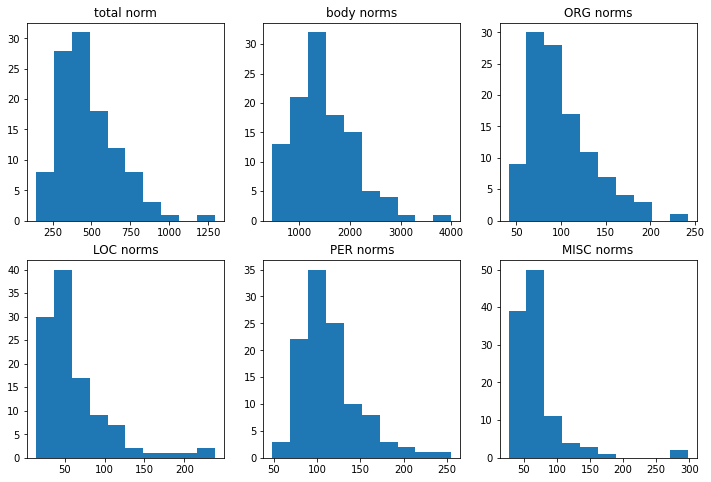

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
_ = axes[0][0].hist(total_grad_norms)
axes[0][0].set_title('total norm')
_ = axes[0][1].hist(body_grad_norms)
axes[0][1].set_title('body norms')
for i, head in enumerate(heads_grad_norms.keys()):
    j = i+2
    _ = axes[j//3][j%3].hist(heads_grad_norms[head])
    axes[j//3][j%3].set_title(f'{head} norms')

plt.show()

Body's norms are mainly greater than total ones and it's ok because gradients may take negative values.

In [ ]:
print(f'Mean total gradient norm: {np.mean(total_grad_norms)}')
print(f'Mean body gradient norm: {np.mean(body_grad_norms)}')
for head in heads_grad_norms.keys():
    print(f'Mean {head} gradient norm: {np.mean(heads_grad_norms[head])}')

Mean total gradient norm: 479.1625377599561
Mean body gradient norm: 1493.7607202703302
Mean ORG gradient norm: 100.52260801141912
Mean LOC gradient norm: 61.176813992587
Mean PER gradient norm: 113.64938697814941
Mean MISC gradient norm: 69.2078110261397


So, let's restrict the overall model grandients size to the norm of 500.

### K-fold for multihead model

In [ ]:
N_FOLDS = 5
RANDOM_SEED = 42
N_EPOCHS = 10
BATCH_SIZE = 128

TAG_NAMES = ['ORG', 'LOC', 'PER']
NUM_OF_HEADS = len(TAG_NAMES)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [ ]:
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED)

In [ ]:
all_loss_values = []
all_head_results = []

for i, (train_index, valid_index) in enumerate(kf.split(train_dataset)):
    if i < 3:
        continue
    print(f"FOLD #{i}\n")
    # train_dataset based on conll and defined above specially for multiple-head model input
    train_fold = torch.utils.data.Subset(train_dataset, train_index)
    valid_fold = torch.utils.data.Subset(train_dataset, valid_index)
    
    _train_dataloader = torch.utils.data.DataLoader(train_fold, batch_size=BATCH_SIZE)
    _valid_dataloader = torch.utils.data.DataLoader(valid_fold, batch_size=BATCH_SIZE)

    total_steps = len(train_fold) *  N_EPOCHS

    model = BEbiC(tag_names=TAG_NAMES, hidden_size=512, bert_layers=2, dropout=0.5)
    model.to(device)

    optimizer = AdamW(params=model.parameters(),lr=1e-3)

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    loss_value, head_results = mu.train(model, _train_dataloader, optimizer, device, conll, scheduler, n_epoch=N_EPOCHS,
                                max_grad_norm=500, valid_dataloader=_valid_dataloader, save_model=False)
    
    print(f"Head_results:\n{head_results}")
    all_loss_values.append(loss_value)
    all_head_results.append(head_results)

    # cleaning
    del model
    gc.collect()
    torch.cuda.empty_cache()

    with open(PATH_TO_CHECKPOINT+f"New_results/bebic_5folds/Bebic-5fold_head_results_fold{i}.json", "w") as f:
        json.dump(head_results, f)

    with open(PATH_TO_CHECKPOINT+f"New_results/bebic_5folds/Bebic-5fold_loss_values_fold{i}.json", "w") as f:
        json.dump(loss_value, f)


#with open(PATH_TO_CHECKPOINT+"BEbic-5fold_head_results.json", "w") as f:
#    json.dump(all_head_results, f)

#with open(PATH_TO_CHECKPOINT+"BEbic-5fold_loss_values.json", "w") as f:
#    json.dump(all_loss_values, f)

## Train model with 3 heads and best params

In [ ]:
TAG_NAMES = ['ORG', 'LOC', 'PER']
NUM_OF_HEADS = len(TAG_NAMES)

In [ ]:
train_dataset, train_sampler, train_dataloader = dalo.create_dataloader(conll, bert_tokenizer, TAG_NAMES, batch_size=64)

In [ ]:
valid_dataset, valid_sampler, valid_dataloader = dalo.create_dataloader(conll, bert_tokenizer, TAG_NAMES,
                                                                        'valid', desired_pad=train_dataset[0][0].shape[0])

In [ ]:
model = BEbiC(tag_names=TAG_NAMES, hidden_size=512, bert_layers=2, dropout=0.5)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [ ]:
N_EPOCHS = 12
total_steps = len(train_dataloader) *  N_EPOCHS

In [ ]:
optimizer = AdamW(params=model.parameters(),lr=1e-3)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

if device.type != 'cpu':
    model.to(device)

loss_value, head_results = mu.train(model, train_dataloader, optimizer, device, conll, scheduler, n_epoch=N_EPOCHS, max_grad_norm=500,
                                valid_dataloader=valid_dataloader, path_to_save=PATH_TO_NEW_CHECKPOINT+'best_bebic_3_tags.pth')

In [ ]:
mu.eval_model(model, valid_dataloader, device, conll)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


({'LOC': {'acc': 0.9939689447668171, 'f1': 0.9363243695137244},
  'ORG': {'acc': 0.9802681065978939, 'f1': 0.6515723270440251},
  'PER': {'acc': 0.9961718246292715, 'f1': 0.9532004830917874}},
 219.55645321798156,
 0.9901362919979941,
 0.8470323932165122)

We have very good quality on all labels.

## The fourth head

In [14]:
checkpoint = torch.load(PATH_TO_NEW_CHECKPOINT+'best_bebic_3_tags_v1.pth')
model = checkpoint['model']
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [ ]:
model.heads

ModuleDict(
  (ORG): ModuleDict(
    (linear): Linear(in_features=1024, out_features=4, bias=True)
    (crf): CRF(num_tags=4)
  )
  (LOC): ModuleDict(
    (linear): Linear(in_features=1024, out_features=4, bias=True)
    (crf): CRF(num_tags=4)
  )
  (PER): ModuleDict(
    (linear): Linear(in_features=1024, out_features=4, bias=True)
    (crf): CRF(num_tags=4)
  )
)

In [ ]:
model.train()

In [ ]:
model.add_head('MISC')

In [ ]:
for head in ['LOC', 'ORG', 'PER']:
    model.freeze_head(head)

In [ ]:
model.active_heads

{'LOC': False, 'MISC': True, 'ORG': False, 'PER': False}

Now let's try to keep 85% of examples with one or more tags MISC and 15% without it. So, we would simulate the real case of receiving new data with new tag.

In [13]:
TAG_NAMES = ['ORG', 'LOC', 'PER', 'MISC']#list(model.heads.keys())
NUM_OF_HEADS = len(TAG_NAMES)
BATCH_SIZE=32
RANDOM_SEED=42
N_EPOCHS = 15

In [14]:
TAG_NAMES

['ORG', 'LOC', 'PER', 'MISC']

In [15]:
indexes_with_misc = [i for i, s in enumerate(conll.labels['train']) if 'B-MISC' in s]
indexes_without_misc = [i for i in range(len(conll.labels['train'])) if i not in indexes_with_misc]

In [16]:
print(f"# sentences with MISC: {len(indexes_with_misc)}")
print(f"# sentences without MISC: {len(indexes_without_misc)}")

# sentences with MISC: 2698
# sentences without MISC: 11343


Also, let's consider multiple "random" cases.

In [ ]:
results_dict = {}
for freezed_epochs in range(3,4):
  print(f"FREEZED_EPOCHS:{freezed_epochs}")
  seed_results_dict = {}
  for seed in [1, 12, 123, 1234, 12345]:
    print(f"SEED:{seed}")
    np.random.seed(seed)
    seed_results_dict[seed] = {}

    for n_train_samples in range(100, 351, 50):
        print(f"NUMBER OF TRAIN SAMPLES: {n_train_samples}")
        
        torch.cuda.empty_cache()

        checkpoint = torch.load(PATH_TO_NEW_CHECKPOINT+'best_bebic_3_tags_v1.pth')
        model = checkpoint['model']
        model.load_state_dict(checkpoint['state_dict'])
        model.train()
        model.add_head('MISC')

        for head in ['LOC', 'ORG', 'PER']:
            model.freeze_head(head)
        
        # I just remember that max sequence length in train is 173
        all_valid_dataset, all_valid_sampler, all_valid_dataloader = dalo.create_dataloader(conll, bert_tokenizer, TAG_NAMES,
                                                                            'valid', desired_pad=173,
                                                                            batch_size=128)

        # train indexes
        n_train_with_misc = int(n_train_samples*0.85)
        train_misk_indexes = np.random.choice(indexes_with_misc, n_train_with_misc)
        train_nmisk_indexes = np.random.choice(indexes_without_misc, n_train_samples-n_train_with_misc)
        train_indexes = np.append(train_misk_indexes, train_nmisk_indexes)

        # let's create small validation data with the same proportion of MISC samples from the train data
        n_valid_samples = int(n_train_samples/4)
        _idxes_with_misc = [i for i in indexes_with_misc if i not in train_misk_indexes]
        _idxes_without_misc = [i for i in indexes_without_misc if i not in train_nmisk_indexes]

        # validation indexes
        n_valid_with_misc = int(n_valid_samples*0.85)
        valid_misk_indexes = np.random.choice(_idxes_with_misc, n_valid_with_misc)
        valid_nmisk_indexes = np.random.choice(_idxes_without_misc, n_valid_samples-n_valid_with_misc)
        valid_indexes = np.append(valid_misk_indexes, valid_nmisk_indexes)

        train_dataset, train_sampler, train_dataloader = dalo.create_dataloader(conll, bert_tokenizer, TAG_NAMES, 
                                                                      desired_pad=173, batch_size=BATCH_SIZE,
                                                                      indexes=train_indexes)
        
        valid_dataset, valid_sampler, valid_dataloader = dalo.create_dataloader(conll, bert_tokenizer, TAG_NAMES,
                                                                            desired_pad=173, batch_size=BATCH_SIZE,
                                                                            indexes=valid_indexes)
        
        total_steps = len(train_dataloader) *  N_EPOCHS

        optimizer = AdamW(params=model.parameters(),lr=1e-3)

        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=total_steps
        )

        if device.type != 'cpu':
            model.to(device)

        model.freeze_body()

        loss_value, head_results = mu.train(model, train_dataloader, optimizer, 
                                            device, conll, scheduler, 
                                            n_epoch=freezed_epochs, 
                                            max_grad_norm=500,
                                            valid_dataloader=valid_dataloader,
                                            save_model=False)
        
        seed_results_dict[seed][n_train_samples] = {}
        seed_results_dict[seed][n_train_samples]['freezed_loss_values'] = loss_value
        seed_results_dict[seed][n_train_samples]['freezed_head_results'] = head_results
        
        model.unfreeze_body()

        loss_value, head_results = mu.train(model, train_dataloader, optimizer, 
                                            device, conll, scheduler, 
                                            n_epoch=N_EPOCHS-freezed_epochs,
                                            max_grad_norm=500,
                                            valid_dataloader=valid_dataloader,
                                            save_model=False)

        seed_results_dict[seed][n_train_samples]['loss_values'] = loss_value
        seed_results_dict[seed][n_train_samples]['head_results'] = head_results

        # eval model on the all validation data
        head_results_all, mean_loss, mean_acc, mean_f1 = mu.eval_model(model, all_valid_dataloader, device, conll)
        print(f"mean validation loss: {mean_loss}")
        print(f"mean validation accuracy: {mean_acc}")
        print(f"mean validation f1-score: {mean_f1}")

        seed_results_dict[seed][n_train_samples]["head_results_all"] = head_results_all
        seed_results_dict[seed][n_train_samples]["mean_loss"] = mean_loss
        seed_results_dict[seed][n_train_samples]["mean_acc"] = mean_acc
        seed_results_dict[seed][n_train_samples]["mean_f1"] = mean_f1
  
  results_dict[f"{freezed_epochs}_freezed_epochs"] = seed_results_dict

  with open(PATH_TO_NEW_CHECKPOINT+f"4th_head/results_dict_freezed{freezed_epochs}.json", "w") as f:
      json.dump(seed_results_dict, f)


FREEZED_EPOCHS:3
SEED:1
NUMBER OF TRAIN SAMPLES: 100


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")
  0%|          | 0/4 [00:00<?, ?it/s]


Epoch #0


100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Average train loss: 259.3961191177368


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 669.4737968444824
Mean validation accuracy: 0.9666172106824926
Mean validation F1-score: 0.6216666666666666


Epoch #1


100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Average train loss: 157.81902933120728


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 374.14686584472656
Mean validation accuracy: 0.9666172106824926
Mean validation F1-score: 0.6216666666666666


Epoch #2


100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


Average train loss: 95.58924055099487


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 330.698055267334
Mean validation accuracy: 0.9666172106824926
Mean validation F1-score: 0.6216666666666666


Epoch #0


100%|██████████| 4/4 [00:04<00:00,  1.13s/it]


Average train loss: 81.46721982955933


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 274.6774082183838
Mean validation accuracy: 0.9651335311572701
Mean validation F1-score: 0.6195970695970696


Epoch #1


100%|██████████| 4/4 [00:04<00:00,  1.15s/it]


Average train loss: 64.0461916923523


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 272.5700092315674
Mean validation accuracy: 0.9643916913946587
Mean validation F1-score: 0.5928571428571429


Epoch #2


100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


Average train loss: 57.09231960773468


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 251.1776065826416
Mean validation accuracy: 0.9658753709198813
Mean validation F1-score: 0.6324175824175824


Epoch #3


100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


Average train loss: 51.797268867492676


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 247.2833251953125
Mean validation accuracy: 0.966246290801187
Mean validation F1-score: 0.6363805970149254


Epoch #4


100%|██████████| 4/4 [00:04<00:00,  1.15s/it]


Average train loss: 48.659082889556885


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 236.6438980102539
Mean validation accuracy: 0.967359050445104
Mean validation F1-score: 0.6531260735142563


Epoch #5


100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


Average train loss: 49.08342504501343


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 233.15218353271484
Mean validation accuracy: 0.9669881305637983
Mean validation F1-score: 0.6448943661971831


Epoch #6


100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


Average train loss: 44.49103260040283


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 231.77352142333984
Mean validation accuracy: 0.9669881305637983
Mean validation F1-score: 0.6448943661971831


Epoch #7


100%|██████████| 4/4 [00:04<00:00,  1.15s/it]


Average train loss: 43.11481952667236


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 233.02910995483398
Mean validation accuracy: 0.9669881305637983
Mean validation F1-score: 0.6448943661971831


Epoch #8


100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


Average train loss: 42.88358390331268


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 238.06809616088867
Mean validation accuracy: 0.9669881305637983
Mean validation F1-score: 0.6448943661971831


Epoch #9


100%|██████████| 4/4 [00:04<00:00,  1.15s/it]


Average train loss: 41.607136487960815


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 233.55327606201172
Mean validation accuracy: 0.9669881305637983
Mean validation F1-score: 0.6448943661971831


Epoch #10


100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


Average train loss: 39.920011043548584


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 233.11602020263672
Mean validation accuracy: 0.9669881305637983
Mean validation F1-score: 0.6442508710801393


Epoch #11


100%|██████████| 4/4 [00:04<00:00,  1.15s/it]


Average train loss: 40.476844787597656
Mean validation loss: 234.63557815551758
Mean validation accuracy: 0.9666172106824926
Mean validation F1-score: 0.6404206433368682

mean validation loss: 566.2084770687093
mean validation accuracy: 0.9848753492370514
mean validation f1-score: 0.6264454338070723
NUMBER OF TRAIN SAMPLES: 150


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch #0


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


Average train loss: 221.42869262695314


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 402.1677474975586
Mean validation accuracy: 0.9774571686203788
Mean validation F1-score: 0.634887317719841


Epoch #1


100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


Average train loss: 99.31134948730468


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 295.58747482299805
Mean validation accuracy: 0.9774571686203788
Mean validation F1-score: 0.634887317719841


Epoch #2


100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


Average train loss: 84.62430114746094


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 296.29689598083496
Mean validation accuracy: 0.9774571686203788
Mean validation F1-score: 0.634887317719841


Epoch #0


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


Average train loss: 72.77585296630859


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 194.55876541137695
Mean validation accuracy: 0.9761045987376015
Mean validation F1-score: 0.6109657947686117


Epoch #1


100%|██████████| 5/5 [00:06<00:00,  1.33s/it]


Average train loss: 56.964849853515624


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PAD seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 164.15667915344238
Mean validation accuracy: 0.9797114517583408
Mean validation F1-score: 0.6908479100408905


Epoch #2


100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


Average train loss: 47.78697967529297


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 164.3225440979004
Mean validation accuracy: 0.9835437330928765
Mean validation F1-score: 0.7384128686945588


Epoch #3


100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


Average train loss: 44.00550994873047


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 141.9072780609131
Mean validation accuracy: 0.9855725879170423
Mean validation F1-score: 0.7597309757236228


Epoch #4


100%|██████████| 5/5 [00:06<00:00,  1.33s/it]


Average train loss: 41.173841857910155


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 130.12339782714844
Mean validation accuracy: 0.9857980162308386
Mean validation F1-score: 0.7522519335974345


Epoch #5


100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


Average train loss: 38.79727439880371


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 132.6819248199463
Mean validation accuracy: 0.986248872858431
Mean validation F1-score: 0.7507168458781363


Epoch #6


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


Average train loss: 37.72080345153809


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 127.52795028686523
Mean validation accuracy: 0.9873760144274121
Mean validation F1-score: 0.7473798649281085


Epoch #7


100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


Average train loss: 35.08853607177734


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 131.82127380371094
Mean validation accuracy: 0.9876014427412083
Mean validation F1-score: 0.7439104923024187


Epoch #8


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


Average train loss: 34.08527526855469


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 132.73945808410645
Mean validation accuracy: 0.9873760144274121
Mean validation F1-score: 0.7448478751295653


Epoch #9


100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


Average train loss: 33.81499710083008


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 126.80971717834473
Mean validation accuracy: 0.9880522993688008
Mean validation F1-score: 0.7498002560819462


Epoch #10


100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


Average train loss: 34.417911529541016


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 130.68842697143555
Mean validation accuracy: 0.9880522993688008
Mean validation F1-score: 0.7540616197183099


Epoch #11


100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


Average train loss: 32.65121994018555
Mean validation loss: 128.35247611999512
Mean validation accuracy: 0.9878268710550046
Mean validation F1-score: 0.7500616197183099

mean validation loss: 582.3122344796964
mean validation accuracy: 0.9830418547173867
mean validation f1-score: 0.7127564345307299
NUMBER OF TRAIN SAMPLES: 200


  0%|          | 0/7 [00:00<?, ?it/s]


Epoch #0


100%|██████████| 7/7 [00:08<00:00,  1.16s/it]


Average train loss: 184.78043256487166


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 444.78309440612793
Mean validation accuracy: 0.9699785561115082
Mean validation F1-score: 0.6516625559514022


Epoch #1


100%|██████████| 7/7 [00:08<00:00,  1.15s/it]


Average train loss: 85.42888750348773


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 448.3263053894043
Mean validation accuracy: 0.9697998570407433
Mean validation F1-score: 0.6488303554982502


Epoch #2


100%|██████████| 7/7 [00:08<00:00,  1.15s/it]


Average train loss: 83.22031620570591


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 408.0659122467041
Mean validation accuracy: 0.9697998570407433
Mean validation F1-score: 0.6488303554982502


Epoch #0


100%|██████████| 7/7 [00:09<00:00,  1.29s/it]


Average train loss: 67.60129574366978


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 303.00646018981934
Mean validation accuracy: 0.9696211579699785
Mean validation F1-score: 0.6455836022514969


Epoch #1


100%|██████████| 7/7 [00:08<00:00,  1.28s/it]


Average train loss: 56.44695322854178


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 266.2843379974365
Mean validation accuracy: 0.9703359542530379
Mean validation F1-score: 0.6565898393118


Epoch #2


100%|██████████| 7/7 [00:08<00:00,  1.27s/it]


Average train loss: 49.25625474112375


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 255.7929925918579
Mean validation accuracy: 0.9714081486776269
Mean validation F1-score: 0.671619364242315


Epoch #3


100%|██████████| 7/7 [00:08<00:00,  1.28s/it]


Average train loss: 45.784411021641326


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 264.7218761444092
Mean validation accuracy: 0.9719442458899213
Mean validation F1-score: 0.6801420915150423


Epoch #4


100%|██████████| 7/7 [00:08<00:00,  1.28s/it]


Average train loss: 44.726888929094585


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 259.4149103164673
Mean validation accuracy: 0.9712294496068621
Mean validation F1-score: 0.6690980928500874


Epoch #5


100%|██████████| 7/7 [00:08<00:00,  1.28s/it]


Average train loss: 41.72207409994943


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 239.8904390335083
Mean validation accuracy: 0.9724803431022159
Mean validation F1-score: 0.6831708757938266


Epoch #6


100%|██████████| 7/7 [00:08<00:00,  1.27s/it]


Average train loss: 40.14438574654715


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 263.2740669250488
Mean validation accuracy: 0.9717655468191566
Mean validation F1-score: 0.6756160697839645


Epoch #7


100%|██████████| 7/7 [00:08<00:00,  1.28s/it]


Average train loss: 38.42237731388637


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 278.44781017303467
Mean validation accuracy: 0.9712294496068621
Mean validation F1-score: 0.6690371224155435


Epoch #8


100%|██████████| 7/7 [00:08<00:00,  1.28s/it]


Average train loss: 36.76993833269392


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 257.95164012908936
Mean validation accuracy: 0.9724803431022159
Mean validation F1-score: 0.6820741268709908


Epoch #9


100%|██████████| 7/7 [00:09<00:00,  1.30s/it]


Average train loss: 37.279789856501985


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 272.0814847946167
Mean validation accuracy: 0.972301644031451
Mean validation F1-score: 0.6781880168286668


Epoch #10


100%|██████████| 7/7 [00:09<00:00,  1.29s/it]


Average train loss: 35.81014905657087


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 272.53306770324707
Mean validation accuracy: 0.9717655468191566
Mean validation F1-score: 0.6826127955897288


Epoch #11


100%|██████████| 7/7 [00:09<00:00,  1.29s/it]


Average train loss: 35.709626470293315
Mean validation loss: 273.22198009490967
Mean validation accuracy: 0.9724803431022159
Mean validation F1-score: 0.6826127955897288

mean validation loss: 541.3211768074164
mean validation accuracy: 0.984519396088545
mean validation f1-score: 0.6478673999653175
NUMBER OF TRAIN SAMPLES: 250


  0%|          | 0/8 [00:00<?, ?it/s]


Epoch #0


100%|██████████| 8/8 [00:09<00:00,  1.21s/it]


Average train loss: 174.48688888549805


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 448.0690441131592
Mean validation accuracy: 0.9759436469962786
Mean validation F1-score: 0.6146198010815429


Epoch #1


100%|██████████| 8/8 [00:09<00:00,  1.21s/it]


Average train loss: 96.53888988494873


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 431.9272918701172
Mean validation accuracy: 0.9759436469962786
Mean validation F1-score: 0.6146198010815429


Epoch #2


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


Average train loss: 89.60247993469238


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 373.12653732299805
Mean validation accuracy: 0.9752791068580542
Mean validation F1-score: 0.6058812383181009


Epoch #0


100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


Average train loss: 73.02431583404541


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 245.08855628967285
Mean validation accuracy: 0.9755449229133439
Mean validation F1-score: 0.60537826062355


Epoch #1


100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


Average train loss: 60.21594429016113


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 232.04586029052734
Mean validation accuracy: 0.9766081871345029
Mean validation F1-score: 0.6343104936818146


Epoch #2


100%|██████████| 8/8 [00:10<00:00,  1.33s/it]


Average train loss: 56.941481590270996


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 233.35041999816895
Mean validation accuracy: 0.9759436469962786
Mean validation F1-score: 0.6277778956600464


Epoch #3


100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


Average train loss: 52.39299488067627


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 241.38807106018066
Mean validation accuracy: 0.9766081871345029
Mean validation F1-score: 0.6350865654999203


Epoch #4


100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


Average train loss: 49.2717866897583


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 233.0445728302002
Mean validation accuracy: 0.9762094630515683
Mean validation F1-score: 0.6284940894900226


Epoch #5


100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


Average train loss: 47.9007511138916


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 224.09702491760254
Mean validation accuracy: 0.976475279106858
Mean validation F1-score: 0.6314369304634239


Epoch #6


100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


Average train loss: 47.13120174407959


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 235.97570037841797
Mean validation accuracy: 0.976475279106858
Mean validation F1-score: 0.6317478385337995


Epoch #7


100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


Average train loss: 45.348472118377686


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 221.55275535583496
Mean validation accuracy: 0.9763423710792132
Mean validation F1-score: 0.6299498565672902


Epoch #8


100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


Average train loss: 43.65601110458374


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 222.20221328735352
Mean validation accuracy: 0.9763423710792132
Mean validation F1-score: 0.6299498565672902


Epoch #9


100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


Average train loss: 44.965853691101074


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 215.9281883239746
Mean validation accuracy: 0.976475279106858
Mean validation F1-score: 0.6317478385337995


Epoch #10


100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


Average train loss: 42.858338594436646


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 215.2433681488037
Mean validation accuracy: 0.976475279106858
Mean validation F1-score: 0.6317478385337995


Epoch #11


100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


Average train loss: 42.84063482284546
Mean validation loss: 216.75693702697754
Mean validation accuracy: 0.976475279106858
Mean validation F1-score: 0.6317478385337995

mean validation loss: 544.9680404011824
mean validation accuracy: 0.9841701590371803
mean validation f1-score: 0.6187181862348643
NUMBER OF TRAIN SAMPLES: 300


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch #0


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


9: avg loss per batch: 210.21900600857205

Average train loss: 189.19710540771484



  0%|          | 0/10 [00:00<?, ?it/s]

Mean validation loss: 404.7288945515951
Mean validation accuracy: 0.9712163416898792
Mean validation F1-score: 0.6025172328291594


Epoch #1


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


9: avg loss per batch: 98.20923868815105

Average train loss: 88.38831481933593



  0%|          | 0/10 [00:00<?, ?it/s]

Mean validation loss: 375.20495464183665
Mean validation accuracy: 0.9712163416898792
Mean validation F1-score: 0.6025172328291594


Epoch #2


100%|██████████| 10/10 [00:12<00:00,  1.20s/it]


9: avg loss per batch: 87.86876636081271

Average train loss: 79.08188972473144



  0%|          | 0/10 [00:00<?, ?it/s]

Mean validation loss: 336.0944934421115
Mean validation accuracy: 0.9712163416898792
Mean validation F1-score: 0.6025172328291594


Epoch #0


100%|██████████| 10/10 [00:13<00:00,  1.33s/it]


9: avg loss per batch: 70.54662492540147

Average train loss: 63.49196243286133



  0%|          | 0/10 [00:00<?, ?it/s]

Mean validation loss: 278.0366256148727
Mean validation accuracy: 0.9741179201485608
Mean validation F1-score: 0.6657702144706028


Epoch #1


100%|██████████| 10/10 [00:13<00:00,  1.33s/it]


9: avg loss per batch: 60.07376628451877

Average train loss: 54.066389656066896



  0%|          | 0/10 [00:00<?, ?it/s]

Mean validation loss: 247.31912923742223
Mean validation accuracy: 0.975974930362117
Mean validation F1-score: 0.6949092663879118


Epoch #2


100%|██████████| 10/10 [00:13<00:00,  1.31s/it]


9: avg loss per batch: 54.04507806566026

Average train loss: 48.64057025909424



  0%|          | 0/10 [00:00<?, ?it/s]

Mean validation loss: 255.36792147601093
Mean validation accuracy: 0.9760909935004642
Mean validation F1-score: 0.697958569797117


Epoch #3


100%|██████████| 10/10 [00:12<00:00,  1.30s/it]


9: avg loss per batch: 49.619988123575844

Average train loss: 44.65798931121826



  0%|          | 0/10 [00:00<?, ?it/s]

Mean validation loss: 246.3785365069354
Mean validation accuracy: 0.9756267409470751
Mean validation F1-score: 0.6878302518908096


Epoch #4


100%|██████████| 10/10 [00:13<00:00,  1.31s/it]


9: avg loss per batch: 46.5958620707194

Average train loss: 41.93627586364746



  0%|          | 0/10 [00:00<?, ?it/s]

Mean validation loss: 221.3436605665419
Mean validation accuracy: 0.9777158774373259
Mean validation F1-score: 0.7166677703907556


Epoch #5


100%|██████████| 10/10 [00:13<00:00,  1.32s/it]


9: avg loss per batch: 46.02871396806505

Average train loss: 41.42584257125854



  0%|          | 0/10 [00:00<?, ?it/s]

Mean validation loss: 259.6349176477503
Mean validation accuracy: 0.9758588672237697
Mean validation F1-score: 0.689740112306651


Epoch #6


100%|██████████| 10/10 [00:13<00:00,  1.32s/it]


9: avg loss per batch: 43.91659418741862

Average train loss: 39.52493476867676



  0%|          | 0/10 [00:00<?, ?it/s]

Mean validation loss: 231.20270411173504
Mean validation accuracy: 0.9773676880222841
Mean validation F1-score: 0.6986594054434879


Epoch #7


100%|██████████| 10/10 [00:13<00:00,  1.30s/it]


9: avg loss per batch: 42.83354504903158

Average train loss: 38.55019054412842



  0%|          | 0/10 [00:00<?, ?it/s]

Mean validation loss: 230.9883815624096
Mean validation accuracy: 0.9770194986072424
Mean validation F1-score: 0.6904468450570146


Epoch #8


100%|██████████| 10/10 [00:13<00:00,  1.31s/it]


9: avg loss per batch: 41.224218156602646

Average train loss: 37.101796340942386



  0%|          | 0/10 [00:00<?, ?it/s]

Mean validation loss: 229.4860277529116
Mean validation accuracy: 0.9777158774373258
Mean validation F1-score: 0.7029336505840333


Epoch #9


100%|██████████| 10/10 [00:13<00:00,  1.30s/it]


9: avg loss per batch: 39.84731313917372

Average train loss: 35.86258182525635



  0%|          | 0/10 [00:00<?, ?it/s]

Mean validation loss: 213.38425219500505
Mean validation accuracy: 0.9782961931290621
Mean validation F1-score: 0.7131752631752631


Epoch #10


100%|██████████| 10/10 [00:13<00:00,  1.33s/it]


9: avg loss per batch: 40.000274658203125

Average train loss: 36.000247192382815



  0%|          | 0/10 [00:00<?, ?it/s]

Mean validation loss: 217.07173552336516
Mean validation accuracy: 0.9784122562674094
Mean validation F1-score: 0.7153025832553929


Epoch #11


100%|██████████| 10/10 [00:13<00:00,  1.32s/it]


9: avg loss per batch: 39.55853324466281

Average train loss: 35.602679920196536


Mean validation loss: 214.25393676757815
Mean validation accuracy: 0.9784122562674094
Mean validation F1-score: 0.714825671778313

mean validation loss: 508.5875384414605
mean validation accuracy: 0.9864200515796261
mean validation f1-score: 0.7555142538759263
NUMBER OF TRAIN SAMPLES: 350


  0%|          | 0/11 [00:00<?, ?it/s]


Epoch #0


 91%|█████████ | 10/11 [00:12<00:01,  1.22s/it]


9: avg loss per batch: 172.75696478949652



100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


Average train loss: 148.7315868030895


  0%|          | 0/11 [00:00<?, ?it/s]

Mean validation loss: 500.8889150266293
Mean validation accuracy: 0.9741314199395771
Mean validation F1-score: 0.6425372921479706


Epoch #1


 91%|█████████ | 10/11 [00:12<00:01,  1.23s/it]


9: avg loss per batch: 103.3685425652398



100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


Average train loss: 92.59681736339222


  0%|          | 0/11 [00:00<?, ?it/s]

Mean validation loss: 430.2011174802428
Mean validation accuracy: 0.9741314199395771
Mean validation F1-score: 0.6425372921479706


Epoch #2


 91%|█████████ | 10/11 [00:12<00:01,  1.24s/it]


9: avg loss per batch: 90.37726253933377



100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


Average train loss: 81.25935155695134


  0%|          | 0/11 [00:00<?, ?it/s]

Mean validation loss: 394.4097593801993
Mean validation accuracy: 0.9741314199395771
Mean validation F1-score: 0.6425372921479706


Epoch #0


 91%|█████████ | 10/11 [00:13<00:01,  1.35s/it]


9: avg loss per batch: 76.91145451863606



100%|██████████| 11/11 [00:14<00:00,  1.35s/it]


Average train loss: 67.59717455777255


  0%|          | 0/11 [00:00<?, ?it/s]

Mean validation loss: 298.29986063639325
Mean validation accuracy: 0.9736593655589124
Mean validation F1-score: 0.6415000202784789


Epoch #1


 91%|█████████ | 10/11 [00:13<00:01,  1.35s/it]


9: avg loss per batch: 62.64571762084961



100%|██████████| 11/11 [00:14<00:00,  1.35s/it]


Average train loss: 56.792776281183414


  0%|          | 0/11 [00:00<?, ?it/s]

Mean validation loss: 286.5008477105035
Mean validation accuracy: 0.976869335347432
Mean validation F1-score: 0.6763264421483811


Epoch #2


 91%|█████████ | 10/11 [00:13<00:01,  1.36s/it]


9: avg loss per batch: 57.5446908738878



100%|██████████| 11/11 [00:14<00:00,  1.35s/it]


Average train loss: 49.62314310940829


  0%|          | 0/11 [00:00<?, ?it/s]

Mean validation loss: 285.90410981354887
Mean validation accuracy: 0.9789463746223565
Mean validation F1-score: 0.6917963940773837


Epoch #3


 91%|█████████ | 10/11 [00:13<00:01,  1.37s/it]


9: avg loss per batch: 54.67026011149088



100%|██████████| 11/11 [00:14<00:00,  1.35s/it]


Average train loss: 48.03156904740767


  0%|          | 0/11 [00:00<?, ?it/s]

Mean validation loss: 271.09432022659865
Mean validation accuracy: 0.9784743202416918
Mean validation F1-score: 0.693392650152901


Epoch #4


 91%|█████████ | 10/11 [00:13<00:01,  1.36s/it]


9: avg loss per batch: 52.00210656060113



100%|██████████| 11/11 [00:14<00:00,  1.36s/it]


Average train loss: 45.80653797496449


  0%|          | 0/11 [00:00<?, ?it/s]

Mean validation loss: 282.69263316966874
Mean validation accuracy: 0.9786631419939577
Mean validation F1-score: 0.6848381041845547


Epoch #5


 91%|█████████ | 10/11 [00:13<00:01,  1.37s/it]


9: avg loss per batch: 49.312784830729164



100%|██████████| 11/11 [00:14<00:00,  1.36s/it]


Average train loss: 43.91854130138051


  0%|          | 0/11 [00:00<?, ?it/s]

Mean validation loss: 271.8895144992405
Mean validation accuracy: 0.9841389728096677
Mean validation F1-score: 0.7684515446291228


Epoch #6


 91%|█████████ | 10/11 [00:13<00:01,  1.36s/it]


9: avg loss per batch: 44.93607669406467



100%|██████████| 11/11 [00:14<00:00,  1.35s/it]


Average train loss: 42.034946788441054


  0%|          | 0/11 [00:00<?, ?it/s]

Mean validation loss: 269.88128859908494
Mean validation accuracy: 0.985083081570997
Mean validation F1-score: 0.7844229697281536


Epoch #7


 91%|█████████ | 10/11 [00:13<00:01,  1.37s/it]


9: avg loss per batch: 44.498089684380425



100%|██████████| 11/11 [00:14<00:00,  1.36s/it]


Average train loss: 40.53329502452504


  0%|          | 0/11 [00:00<?, ?it/s]

Mean validation loss: 271.946635917381
Mean validation accuracy: 0.9838557401812689
Mean validation F1-score: 0.7698203317115359


Epoch #8


 91%|█████████ | 10/11 [00:13<00:01,  1.36s/it]


9: avg loss per batch: 45.58339733547635



100%|██████████| 11/11 [00:14<00:00,  1.36s/it]


Average train loss: 39.35997910933061


  0%|          | 0/11 [00:00<?, ?it/s]

Mean validation loss: 271.26598160355184
Mean validation accuracy: 0.9847054380664653
Mean validation F1-score: 0.7795370470322516


Epoch #9


 91%|█████████ | 10/11 [00:13<00:01,  1.36s/it]


9: avg loss per batch: 43.64425913492838



100%|██████████| 11/11 [00:14<00:00,  1.36s/it]


Average train loss: 38.37710051103072


  0%|          | 0/11 [00:00<?, ?it/s]

Mean validation loss: 255.19106928507483
Mean validation accuracy: 0.9845166163141994
Mean validation F1-score: 0.7860677559067104


Epoch #10


 91%|█████████ | 10/11 [00:13<00:01,  1.35s/it]


9: avg loss per batch: 41.68745337592231



100%|██████████| 11/11 [00:14<00:00,  1.34s/it]


Average train loss: 37.96682288429954


  0%|          | 0/11 [00:00<?, ?it/s]

Mean validation loss: 258.4138926753292
Mean validation accuracy: 0.9846110271903323
Mean validation F1-score: 0.781794602346537


Epoch #11


 91%|█████████ | 10/11 [00:13<00:01,  1.37s/it]


9: avg loss per batch: 42.61347961425781



100%|██████████| 11/11 [00:14<00:00,  1.36s/it]


Average train loss: 37.45913349498402
Mean validation loss: 264.23223283555774
Mean validation accuracy: 0.9847054380664653
Mean validation F1-score: 0.7831074168797953

mean validation loss: 509.37057168440447
mean validation accuracy: 0.9871856866537718
mean validation f1-score: 0.7627106565433488
SEED:12
NUMBER OF TRAIN SAMPLES: 100


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch #0


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Average train loss: 166.37567901611328


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 370.7675838470459
Mean validation accuracy: 0.9736477115117892
Mean validation F1-score: 0.6728739002932551


Epoch #1


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Average train loss: 86.87837934494019


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 311.12114906311035
Mean validation accuracy: 0.9736477115117892
Mean validation F1-score: 0.6728739002932551


Epoch #2


100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Average train loss: 77.36849355697632


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 322.63062858581543
Mean validation accuracy: 0.9736477115117892
Mean validation F1-score: 0.6728739002932551


Epoch #0


100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Average train loss: 69.89150953292847


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 234.511381149292
Mean validation accuracy: 0.9736477115117892
Mean validation F1-score: 0.6728739002932551


Epoch #1


100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Average train loss: 56.326910853385925


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 204.31243896484375
Mean validation accuracy: 0.9736477115117892
Mean validation F1-score: 0.6666666666666667


Epoch #2


100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


Average train loss: 48.88370752334595


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 186.39200973510742
Mean validation accuracy: 0.9736477115117892
Mean validation F1-score: 0.6666666666666667


Epoch #3


100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


Average train loss: 45.0170578956604


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 179.3223648071289
Mean validation accuracy: 0.9719140083217753
Mean validation F1-score: 0.6363636363636364


Epoch #4


100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


Average train loss: 40.73538589477539


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 177.75056076049805
Mean validation accuracy: 0.9726074895977809
Mean validation F1-score: 0.641649157500103


Epoch #5


100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Average train loss: 38.3928747177124


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 170.42131805419922
Mean validation accuracy: 0.9736477115117892
Mean validation F1-score: 0.6554347826086956


Epoch #6


100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Average train loss: 36.71151626110077


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 175.3780632019043
Mean validation accuracy: 0.9736477115117892
Mean validation F1-score: 0.6658107116654438


Epoch #7


100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Average train loss: 35.83426904678345


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 175.82705307006836
Mean validation accuracy: 0.970873786407767
Mean validation F1-score: 0.6560617418563446


Epoch #8


100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Average train loss: 34.35197877883911


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 176.90763473510742
Mean validation accuracy: 0.9719140083217753
Mean validation F1-score: 0.6558901171423858


Epoch #9


100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Average train loss: 34.61596322059631


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 178.36139297485352
Mean validation accuracy: 0.9729542302357836
Mean validation F1-score: 0.6610436259143155


Epoch #10


100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Average train loss: 34.22283983230591


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 178.1275978088379
Mean validation accuracy: 0.9733009708737864
Mean validation F1-score: 0.6557290000639754


Epoch #11


100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Average train loss: 32.448803663253784
Mean validation loss: 180.48201751708984
Mean validation accuracy: 0.9726074895977809
Mean validation F1-score: 0.6558352925809823

mean validation loss: 593.505828477051
mean validation accuracy: 0.9832299054373523
mean validation f1-score: 0.6387200982669539
NUMBER OF TRAIN SAMPLES: 150


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch #0


100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


Average train loss: 174.77039184570313


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 341.17019748687744
Mean validation accuracy: 0.970508658008658
Mean validation F1-score: 0.6508097165991903


Epoch #1


100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


Average train loss: 91.09662017822265


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 335.8114957809448
Mean validation accuracy: 0.9702380952380952
Mean validation F1-score: 0.650413564929694


Epoch #2


100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


Average train loss: 85.36451416015625


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 315.13758277893066
Mean validation accuracy: 0.9702380952380952
Mean validation F1-score: 0.650413564929694


Epoch #0


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


Average train loss: 77.57510299682617


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 241.60610008239746
Mean validation accuracy: 0.9672619047619048
Mean validation F1-score: 0.6385281385281385


Epoch #1


100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


Average train loss: 60.16617660522461


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 217.7989387512207
Mean validation accuracy: 0.9678030303030303
Mean validation F1-score: 0.6211538461538462


Epoch #2


100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


Average train loss: 53.306541442871094


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 237.37288856506348
Mean validation accuracy: 0.9650974025974026
Mean validation F1-score: 0.6166666666666667


Epoch #3


100%|██████████| 5/5 [00:06<00:00,  1.29s/it]


Average train loss: 51.096788787841795


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 240.1720371246338
Mean validation accuracy: 0.9650974025974026
Mean validation F1-score: 0.6051724137931034


Epoch #4


100%|██████████| 5/5 [00:06<00:00,  1.29s/it]


Average train loss: 46.22966995239258


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 237.01416873931885
Mean validation accuracy: 0.9642857142857143
Mean validation F1-score: 0.6029746115953013


Epoch #5


100%|██████████| 5/5 [00:06<00:00,  1.29s/it]


Average train loss: 43.933860778808594


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 254.01737689971924
Mean validation accuracy: 0.9664502164502164
Mean validation F1-score: 0.6230811403508771


Epoch #6


100%|██████████| 5/5 [00:06<00:00,  1.29s/it]


Average train loss: 40.964812469482425


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 242.30665493011475
Mean validation accuracy: 0.9656385281385281
Mean validation F1-score: 0.6086466165413533


Epoch #7


100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


Average train loss: 37.48196563720703


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 248.81403160095215
Mean validation accuracy: 0.9667207792207793
Mean validation F1-score: 0.6127150400272526


Epoch #8


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


Average train loss: 37.81947631835938


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 234.99040412902832
Mean validation accuracy: 0.9675324675324676
Mean validation F1-score: 0.6208586883029074


Epoch #9


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


Average train loss: 37.540636444091795


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 234.51703262329102
Mean validation accuracy: 0.9683441558441559
Mean validation F1-score: 0.6399529297192015


Epoch #10


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


Average train loss: 35.872030639648436


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 235.5783395767212
Mean validation accuracy: 0.9680735930735931
Mean validation F1-score: 0.6378174220507875


Epoch #11


100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


Average train loss: 36.75395202636719
Mean validation loss: 239.91766929626465
Mean validation accuracy: 0.9680735930735931
Mean validation F1-score: 0.6378174220507875

mean validation loss: 546.9694356058646
mean validation accuracy: 0.9846772243713733
mean validation f1-score: 0.6249696746837954
NUMBER OF TRAIN SAMPLES: 200


  0%|          | 0/7 [00:00<?, ?it/s]


Epoch #0


100%|██████████| 7/7 [00:08<00:00,  1.16s/it]


Average train loss: 196.07458986554826


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 431.1257724761963
Mean validation accuracy: 0.9701916252661461
Mean validation F1-score: 0.5904366298698835


Epoch #1


100%|██████████| 7/7 [00:08<00:00,  1.15s/it]


Average train loss: 82.64458084106445


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 390.5335273742676
Mean validation accuracy: 0.9701916252661461
Mean validation F1-score: 0.5904366298698835


Epoch #2


100%|██████████| 7/7 [00:08<00:00,  1.16s/it]


Average train loss: 79.34805951799665


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 378.6629867553711
Mean validation accuracy: 0.9701916252661461
Mean validation F1-score: 0.5904366298698835


Epoch #0


100%|██████████| 7/7 [00:09<00:00,  1.30s/it]


Average train loss: 64.19797951834542


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 286.52328872680664
Mean validation accuracy: 0.9691270404542228
Mean validation F1-score: 0.5961555841182495


Epoch #1


100%|██████████| 7/7 [00:09<00:00,  1.29s/it]


Average train loss: 50.199991362435476


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 289.8697395324707
Mean validation accuracy: 0.974804826117814
Mean validation F1-score: 0.7182797623165971


Epoch #2


100%|██████████| 7/7 [00:08<00:00,  1.28s/it]


Average train loss: 45.5738765171596


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 285.3010902404785
Mean validation accuracy: 0.975514549325763
Mean validation F1-score: 0.7276477102468895


Epoch #3


100%|██████████| 7/7 [00:08<00:00,  1.28s/it]


Average train loss: 43.55527251107352


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 237.00736618041992
Mean validation accuracy: 0.9758694109297374
Mean validation F1-score: 0.7058210587075373


Epoch #4


100%|██████████| 7/7 [00:08<00:00,  1.28s/it]


Average train loss: 39.79249790736607


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 250.52446937561035
Mean validation accuracy: 0.9767565649396736
Mean validation F1-score: 0.718567749618014


Epoch #5


100%|██████████| 7/7 [00:09<00:00,  1.29s/it]


Average train loss: 36.674130984715056


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 253.19741821289062
Mean validation accuracy: 0.977111426543648
Mean validation F1-score: 0.7287816943486276


Epoch #6


100%|██████████| 7/7 [00:09<00:00,  1.29s/it]


Average train loss: 35.22985594613211


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 261.294677734375
Mean validation accuracy: 0.9772888573456352
Mean validation F1-score: 0.7205846950683406


Epoch #7


100%|██████████| 7/7 [00:09<00:00,  1.29s/it]


Average train loss: 33.296002524239675


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 267.21630859375
Mean validation accuracy: 0.9767565649396734
Mean validation F1-score: 0.7227940515507508


Epoch #8


100%|██████████| 7/7 [00:08<00:00,  1.28s/it]


Average train loss: 31.752200262887136


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 228.88712310791016
Mean validation accuracy: 0.9795954577714692
Mean validation F1-score: 0.7566968231299934


Epoch #9


100%|██████████| 7/7 [00:09<00:00,  1.30s/it]


Average train loss: 31.704216275896346


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 249.89173889160156
Mean validation accuracy: 0.9792405961674946
Mean validation F1-score: 0.756246574156649


Epoch #10


100%|██████████| 7/7 [00:09<00:00,  1.30s/it]


Average train loss: 31.102954592023575


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 282.47532844543457
Mean validation accuracy: 0.978708303761533
Mean validation F1-score: 0.7501871967633076


Epoch #11


100%|██████████| 7/7 [00:09<00:00,  1.29s/it]


Average train loss: 30.703260557992117
Mean validation loss: 277.04308700561523
Mean validation accuracy: 0.9788857345635201
Mean validation F1-score: 0.7525773420105957

mean validation loss: 584.2275462395523
mean validation accuracy: 0.986242075005373
mean validation f1-score: 0.7522023751573921
NUMBER OF TRAIN SAMPLES: 250


  0%|          | 0/8 [00:00<?, ?it/s]


Epoch #0


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


Average train loss: 178.21997165679932


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 456.53350257873535
Mean validation accuracy: 0.9722719141323792
Mean validation F1-score: 0.6187013739719672


Epoch #1


100%|██████████| 8/8 [00:09<00:00,  1.21s/it]


Average train loss: 96.84100151062012


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 427.2282304763794
Mean validation accuracy: 0.9722719141323792
Mean validation F1-score: 0.6187013739719672


Epoch #2


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


Average train loss: 89.4239330291748


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 389.1074409484863
Mean validation accuracy: 0.9722719141323792
Mean validation F1-score: 0.6187013739719672


Epoch #0


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


Average train loss: 75.6731367111206


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 297.19066429138184
Mean validation accuracy: 0.9728682170542635
Mean validation F1-score: 0.6466013419553243


Epoch #1


100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


Average train loss: 60.56163930892944


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 302.64811515808105
Mean validation accuracy: 0.9761478831246273
Mean validation F1-score: 0.7009132891485832


Epoch #2


100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


Average train loss: 55.00421380996704


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 274.8018493652344
Mean validation accuracy: 0.979427549194991
Mean validation F1-score: 0.7221478047528558


Epoch #3


100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


Average train loss: 50.473055601119995


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 274.7237596511841
Mean validation accuracy: 0.9797257006559331
Mean validation F1-score: 0.7386648345826633


Epoch #4


100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


Average train loss: 47.432969093322754


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 269.54896545410156
Mean validation accuracy: 0.9795766249254622
Mean validation F1-score: 0.7306366853860278


Epoch #5


100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


Average train loss: 45.17229342460632


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 287.3678665161133
Mean validation accuracy: 0.979129397734049
Mean validation F1-score: 0.7259820574320102


Epoch #6


100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


Average train loss: 43.61549949645996


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 261.74538135528564
Mean validation accuracy: 0.9794275491949911
Mean validation F1-score: 0.7283988213546223


Epoch #7


100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


Average train loss: 42.78616690635681


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 260.86034393310547
Mean validation accuracy: 0.9788312462731068
Mean validation F1-score: 0.7224670157569453


Epoch #8


100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


Average train loss: 41.42405605316162


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 258.66441535949707
Mean validation accuracy: 0.9788312462731067
Mean validation F1-score: 0.7287346567491833


Epoch #9


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


Average train loss: 38.97374677658081


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 284.7186908721924
Mean validation accuracy: 0.9789803220035779
Mean validation F1-score: 0.7301579368649186


Epoch #10


100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


Average train loss: 40.27424883842468


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 274.9018440246582
Mean validation accuracy: 0.9789803220035779
Mean validation F1-score: 0.7320734669952231


Epoch #11


100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


Average train loss: 39.471797943115234
Mean validation loss: 274.95440101623535
Mean validation accuracy: 0.9786821705426356
Mean validation F1-score: 0.729682812860383

mean validation loss: 534.7698828315814
mean validation accuracy: 0.9853085375026864
mean validation f1-score: 0.7383254442433564
NUMBER OF TRAIN SAMPLES: 300


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch #0


100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


9: avg loss per batch: 162.31899049546985

Average train loss: 146.08709144592285



  0%|          | 0/10 [00:00<?, ?it/s]

Mean validation loss: 405.9164848327637
Mean validation accuracy: 0.9706232159847764
Mean validation F1-score: 0.5924241211957726


Epoch #1


100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


9: avg loss per batch: 104.65022744072809

Average train loss: 94.18520469665528



  0%|          | 0/10 [00:00<?, ?it/s]

Mean validation loss: 363.55491934882264
Mean validation accuracy: 0.9706232159847764
Mean validation F1-score: 0.5924241211957726


Epoch #2


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


9: avg loss per batch: 93.3583747016059

Average train loss: 84.02253723144531



  0%|          | 0/10 [00:00<?, ?it/s]

Mean validation loss: 331.1228771916142
Mean validation accuracy: 0.9706232159847764
Mean validation F1-score: 0.5924241211957726


Epoch #0


100%|██████████| 10/10 [00:13<00:00,  1.31s/it]


9: avg loss per batch: 77.63345506456163

Average train loss: 69.87010955810547



  0%|          | 0/10 [00:00<?, ?it/s]

Mean validation loss: 264.8368535924841
Mean validation accuracy: 0.9703853472882968
Mean validation F1-score: 0.6031038149464982


Epoch #1


100%|██████████| 10/10 [00:13<00:00,  1.30s/it]


9: avg loss per batch: 61.96427663167318

Average train loss: 55.76784896850586



  0%|          | 0/10 [00:00<?, ?it/s]

Mean validation loss: 239.81788522225844
Mean validation accuracy: 0.9764509990485253
Mean validation F1-score: 0.700014006234434


Epoch #2


100%|██████████| 10/10 [00:13<00:00,  1.32s/it]


9: avg loss per batch: 56.6010364956326

Average train loss: 50.94093284606934



  0%|          | 0/10 [00:00<?, ?it/s]

Mean validation loss: 232.30997777868203
Mean validation accuracy: 0.9783539486203615
Mean validation F1-score: 0.737330645548506


Epoch #3


100%|██████████| 10/10 [00:13<00:00,  1.32s/it]


9: avg loss per batch: 52.23372925652398

Average train loss: 47.01035633087158



  0%|          | 0/10 [00:00<?, ?it/s]

Mean validation loss: 238.00716272989905
Mean validation accuracy: 0.9774024738344435
Mean validation F1-score: 0.7268410313342826


Epoch #4


100%|██████████| 10/10 [00:13<00:00,  1.32s/it]


9: avg loss per batch: 50.024280336168076

Average train loss: 45.02185230255127



  0%|          | 0/10 [00:00<?, ?it/s]

Mean validation loss: 224.9545457628038
Mean validation accuracy: 0.9782350142721218
Mean validation F1-score: 0.7376004326905143


Epoch #5


100%|██████████| 10/10 [00:13<00:00,  1.31s/it]


9: avg loss per batch: 47.9199021657308

Average train loss: 43.12791194915771



  0%|          | 0/10 [00:00<?, ?it/s]

Mean validation loss: 223.07540822912148
Mean validation accuracy: 0.976569933396765
Mean validation F1-score: 0.7150435947762886


Epoch #6


100%|██████████| 10/10 [00:13<00:00,  1.30s/it]


9: avg loss per batch: 44.25462765163846

Average train loss: 39.82916488647461



  0%|          | 0/10 [00:00<?, ?it/s]

Mean validation loss: 225.13179341068977
Mean validation accuracy: 0.9775214081826832
Mean validation F1-score: 0.721407460322532


Epoch #7


100%|██████████| 10/10 [00:13<00:00,  1.31s/it]


9: avg loss per batch: 44.54917738172743

Average train loss: 40.094259643554686



  0%|          | 0/10 [00:00<?, ?it/s]

Mean validation loss: 234.355665701407
Mean validation accuracy: 0.9772835394862036
Mean validation F1-score: 0.7214334919329735


Epoch #8


100%|██████████| 10/10 [00:13<00:00,  1.31s/it]


9: avg loss per batch: 42.68329768710666

Average train loss: 38.414967918395995



  0%|          | 0/10 [00:00<?, ?it/s]

Mean validation loss: 223.47579306143305
Mean validation accuracy: 0.9787107516650809
Mean validation F1-score: 0.7375626588466662


Epoch #9


100%|██████████| 10/10 [00:13<00:00,  1.32s/it]


9: avg loss per batch: 41.500477684868706

Average train loss: 37.350429916381835



  0%|          | 0/10 [00:00<?, ?it/s]

Mean validation loss: 228.36504166214556
Mean validation accuracy: 0.9788296860133207
Mean validation F1-score: 0.7336511527687998


Epoch #10


100%|██████████| 10/10 [00:13<00:00,  1.32s/it]


9: avg loss per batch: 41.01466178894043

Average train loss: 36.91319561004639



  0%|          | 0/10 [00:00<?, ?it/s]

Mean validation loss: 226.36377080281574
Mean validation accuracy: 0.9784728829686014
Mean validation F1-score: 0.729452579276393


Epoch #11


100%|██████████| 10/10 [00:13<00:00,  1.32s/it]


9: avg loss per batch: 40.457880126105415

Average train loss: 36.41209211349487


Mean validation loss: 226.01876378942418
Mean validation accuracy: 0.9790675547098002
Mean validation F1-score: 0.7396395271395271

mean validation loss: 518.7641137993126
mean validation accuracy: 0.9861749140339566
mean validation f1-score: 0.7496363673104437
NUMBER OF TRAIN SAMPLES: 350


  0%|          | 0/11 [00:00<?, ?it/s]


Epoch #0


 91%|█████████ | 10/11 [00:12<00:01,  1.20s/it]


9: avg loss per batch: 223.72382015652127



100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


Average train loss: 190.89725494384766


  0%|          | 0/11 [00:00<?, ?it/s]

Mean validation loss: 430.0325503879123
Mean validation accuracy: 0.9729347826086956
Mean validation F1-score: 0.6412437655429893


Epoch #1


 91%|█████████ | 10/11 [00:12<00:01,  1.23s/it]


9: avg loss per batch: 105.10782453748915



100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


Average train loss: 93.69657135009766


  0%|          | 0/11 [00:00<?, ?it/s]

Mean validation loss: 376.2555768048322
Mean validation accuracy: 0.9723913043478261
Mean validation F1-score: 0.6346347237797861


Epoch #2


 91%|█████████ | 10/11 [00:12<00:01,  1.23s/it]


9: avg loss per batch: 92.32883877224393



100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


Average train loss: 82.91049679842862


  0%|          | 0/11 [00:00<?, ?it/s]

Mean validation loss: 335.14215681287976
Mean validation accuracy: 0.9723913043478261
Mean validation F1-score: 0.6346347237797861


Epoch #0


 91%|█████████ | 10/11 [00:13<00:01,  1.34s/it]


9: avg loss per batch: 73.8651008605957



100%|██████████| 11/11 [00:14<00:00,  1.35s/it]


Average train loss: 68.8155701377175


  0%|          | 0/11 [00:00<?, ?it/s]

Mean validation loss: 243.59371552643958
Mean validation accuracy: 0.9722826086956522
Mean validation F1-score: 0.6313013564627625


Epoch #1


 91%|█████████ | 10/11 [00:13<00:01,  1.34s/it]


9: avg loss per batch: 65.19953325059679



100%|██████████| 11/11 [00:14<00:00,  1.34s/it]


Average train loss: 58.23951963944869


  0%|          | 0/11 [00:00<?, ?it/s]

Mean validation loss: 228.07191707469798
Mean validation accuracy: 0.9715217391304348
Mean validation F1-score: 0.6219431887940176


Epoch #2


 91%|█████████ | 10/11 [00:13<00:01,  1.35s/it]


9: avg loss per batch: 59.18649249606662



100%|██████████| 11/11 [00:14<00:00,  1.35s/it]


Average train loss: 52.174014351584695


  0%|          | 0/11 [00:00<?, ?it/s]

Mean validation loss: 229.60788585521559
Mean validation accuracy: 0.9720652173913044
Mean validation F1-score: 0.6305723905723906


Epoch #3


 91%|█████████ | 10/11 [00:13<00:01,  1.35s/it]


9: avg loss per batch: 57.65032280815972



100%|██████████| 11/11 [00:14<00:00,  1.35s/it]


Average train loss: 50.46478618275035


  0%|          | 0/11 [00:00<?, ?it/s]

Mean validation loss: 231.27061038547095
Mean validation accuracy: 0.9713043478260869
Mean validation F1-score: 0.629485648191861


Epoch #4


 91%|█████████ | 10/11 [00:13<00:01,  1.36s/it]


9: avg loss per batch: 51.85406578911675



100%|██████████| 11/11 [00:14<00:00,  1.35s/it]


Average train loss: 46.16237362948331


  0%|          | 0/11 [00:00<?, ?it/s]

Mean validation loss: 225.87000783284506
Mean validation accuracy: 0.9716304347826087
Mean validation F1-score: 0.6271668800807093


Epoch #5


 91%|█████████ | 10/11 [00:13<00:01,  1.34s/it]


9: avg loss per batch: 50.33311462402344



100%|██████████| 11/11 [00:14<00:00,  1.35s/it]


Average train loss: 43.5901555148038


  0%|          | 0/11 [00:00<?, ?it/s]

Mean validation loss: 217.60985960783782
Mean validation accuracy: 0.9722826086956521
Mean validation F1-score: 0.6403521412459634


Epoch #6


 91%|█████████ | 10/11 [00:13<00:01,  1.35s/it]


9: avg loss per batch: 46.36359151204427



100%|██████████| 11/11 [00:14<00:00,  1.35s/it]


Average train loss: 40.86804129860618


  0%|          | 0/11 [00:00<?, ?it/s]

Mean validation loss: 224.41811681676793
Mean validation accuracy: 0.9729347826086957
Mean validation F1-score: 0.6429761214069177


Epoch #7


 91%|█████████ | 10/11 [00:13<00:01,  1.35s/it]


9: avg loss per batch: 45.21602588229709



100%|██████████| 11/11 [00:14<00:00,  1.35s/it]


Average train loss: 40.39854257757013


  0%|          | 0/11 [00:00<?, ?it/s]

Mean validation loss: 222.97278227629485
Mean validation accuracy: 0.9733695652173913
Mean validation F1-score: 0.667964857692188


Epoch #8


 91%|█████████ | 10/11 [00:13<00:01,  1.36s/it]


9: avg loss per batch: 44.951805114746094



100%|██████████| 11/11 [00:14<00:00,  1.35s/it]


Average train loss: 39.88403459028764


  0%|          | 0/11 [00:00<?, ?it/s]

Mean validation loss: 220.2801496717665
Mean validation accuracy: 0.9747826086956521
Mean validation F1-score: 0.6915841789861219


Epoch #9


 91%|█████████ | 10/11 [00:13<00:01,  1.35s/it]


9: avg loss per batch: 42.717759450276695



100%|██████████| 11/11 [00:14<00:00,  1.35s/it]


Average train loss: 37.41657742587003


  0%|          | 0/11 [00:00<?, ?it/s]

Mean validation loss: 217.81535311098452
Mean validation accuracy: 0.9759782608695652
Mean validation F1-score: 0.699922463794995


Epoch #10


 91%|█████████ | 10/11 [00:13<00:01,  1.35s/it]


9: avg loss per batch: 41.740169525146484



100%|██████████| 11/11 [00:14<00:00,  1.35s/it]


Average train loss: 37.13113680752841


  0%|          | 0/11 [00:00<?, ?it/s]

Mean validation loss: 222.40151977539062
Mean validation accuracy: 0.9757608695652175
Mean validation F1-score: 0.6973791112886167


Epoch #11


 91%|█████████ | 10/11 [00:13<00:01,  1.35s/it]


9: avg loss per batch: 40.96124352349175



100%|██████████| 11/11 [00:14<00:00,  1.35s/it]


Average train loss: 37.41897929798473
Mean validation loss: 214.9031807228371
Mean validation accuracy: 0.9757608695652175
Mean validation F1-score: 0.6973791112886167

mean validation loss: 459.5693730586142
mean validation accuracy: 0.9859331345368579
mean validation f1-score: 0.670936888176167
SEED:123
NUMBER OF TRAIN SAMPLES: 100


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch #0


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Average train loss: 150.27868127822876


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 348.48291397094727
Mean validation accuracy: 0.9678002894356006
Mean validation F1-score: 0.6016949152542372


Epoch #1


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Average train loss: 84.75137710571289


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 315.5834426879883
Mean validation accuracy: 0.9678002894356006
Mean validation F1-score: 0.6016949152542372


Epoch #2


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Average train loss: 77.14596343040466


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 318.56896591186523
Mean validation accuracy: 0.9678002894356006
Mean validation F1-score: 0.6016949152542372


Epoch #0


100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Average train loss: 74.45349836349487


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 277.4150581359863
Mean validation accuracy: 0.9638205499276411
Mean validation F1-score: 0.5138368462138954


Epoch #1


100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Average train loss: 61.76035952568054


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 228.55503845214844
Mean validation accuracy: 0.9667149059334298
Mean validation F1-score: 0.577485380116959


Epoch #2


100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


Average train loss: 52.79768109321594


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 199.32027435302734
Mean validation accuracy: 0.9678002894356006
Mean validation F1-score: 0.603448275862069


Epoch #3


100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


Average train loss: 47.8373007774353


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 197.2466812133789
Mean validation accuracy: 0.9656295224312591
Mean validation F1-score: 0.556896551724138


Epoch #4


100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Average train loss: 45.93075370788574


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 212.55182266235352
Mean validation accuracy: 0.9634587554269175
Mean validation F1-score: 0.5478056426332288


Epoch #5


100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Average train loss: 49.73208975791931


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 189.54298400878906
Mean validation accuracy: 0.9667149059334298
Mean validation F1-score: 0.584375


Epoch #6


100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Average train loss: 42.54903554916382


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 185.4587173461914
Mean validation accuracy: 0.9678002894356006
Mean validation F1-score: 0.603448275862069


Epoch #7


100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Average train loss: 39.85965967178345


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 182.39200592041016
Mean validation accuracy: 0.9670767004341534
Mean validation F1-score: 0.587823275862069


Epoch #8


100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Average train loss: 38.931262254714966


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 180.52667236328125
Mean validation accuracy: 0.9670767004341534
Mean validation F1-score: 0.587823275862069


Epoch #9


100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Average train loss: 38.461318016052246


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 180.0021095275879
Mean validation accuracy: 0.9670767004341534
Mean validation F1-score: 0.587823275862069


Epoch #10


100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Average train loss: 36.44852900505066


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 182.40128707885742
Mean validation accuracy: 0.9667149059334298
Mean validation F1-score: 0.5860699152542372


Epoch #11


100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Average train loss: 35.84272813796997
Mean validation loss: 182.90884017944336
Mean validation accuracy: 0.9667149059334298
Mean validation F1-score: 0.5860699152542372

mean validation loss: 553.3458887795922
mean validation accuracy: 0.9845261121856865
mean validation f1-score: 0.62327492675016
NUMBER OF TRAIN SAMPLES: 150


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch #0


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


Average train loss: 215.43543701171876


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 374.66395378112793
Mean validation accuracy: 0.9733365949119374
Mean validation F1-score: 0.6040723981900452


Epoch #1


100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


Average train loss: 99.71138153076171


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 285.04651832580566
Mean validation accuracy: 0.973091976516634
Mean validation F1-score: 0.5982584447016731


Epoch #2


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


Average train loss: 89.00139465332032


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 283.84511947631836
Mean validation accuracy: 0.973091976516634
Mean validation F1-score: 0.5982584447016731


Epoch #0


100%|██████████| 5/5 [00:06<00:00,  1.33s/it]


Average train loss: 77.41209335327149


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 203.39710235595703
Mean validation accuracy: 0.9728473581213307
Mean validation F1-score: 0.5831604054859869


Epoch #1


100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


Average train loss: 60.87874908447266


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 180.51618194580078
Mean validation accuracy: 0.974559686888454
Mean validation F1-score: 0.6444122908555192


Epoch #2


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


Average train loss: 55.40189666748047


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 174.4475212097168
Mean validation accuracy: 0.9792074363992171
Mean validation F1-score: 0.704527186847081


Epoch #3


100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


Average train loss: 50.62552490234375


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 177.021390914917
Mean validation accuracy: 0.9801859099804305
Mean validation F1-score: 0.7182094850933499


Epoch #4


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


Average train loss: 45.29471969604492


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 180.8058624267578
Mean validation accuracy: 0.9792074363992171
Mean validation F1-score: 0.727402217595446


Epoch #5


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


Average train loss: 44.067190170288086


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 175.72203254699707
Mean validation accuracy: 0.9789628180039138
Mean validation F1-score: 0.716036737955016


Epoch #6


100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


Average train loss: 42.43353805541992


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 179.5572624206543
Mean validation accuracy: 0.9792074363992171
Mean validation F1-score: 0.7005963029218844


Epoch #7


100%|██████████| 5/5 [00:06<00:00,  1.30s/it]


Average train loss: 42.34739761352539


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 176.36854934692383
Mean validation accuracy: 0.9811643835616438
Mean validation F1-score: 0.7493001113683397


Epoch #8


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


Average train loss: 39.621202087402345


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 176.65705680847168
Mean validation accuracy: 0.9811643835616438
Mean validation F1-score: 0.7396725861158145


Epoch #9


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


Average train loss: 38.82409515380859


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 191.17616844177246
Mean validation accuracy: 0.9806751467710372
Mean validation F1-score: 0.7338319580677397


Epoch #10


100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


Average train loss: 38.63366546630859


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 197.30135345458984
Mean validation accuracy: 0.9811643835616438
Mean validation F1-score: 0.7429025067799457


Epoch #11


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


Average train loss: 38.50373077392578
Mean validation loss: 198.6332893371582
Mean validation accuracy: 0.9816536203522505
Mean validation F1-score: 0.7481656646746826

mean validation loss: 602.7723276620482
mean validation accuracy: 0.9860002955082742
mean validation f1-score: 0.7373001189290647
NUMBER OF TRAIN SAMPLES: 200


  0%|          | 0/7 [00:00<?, ?it/s]


Epoch #0


100%|██████████| 7/7 [00:08<00:00,  1.15s/it]


Average train loss: 222.86527579171317


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 476.38728618621826
Mean validation accuracy: 0.973611111111111
Mean validation F1-score: 0.6432846715328467


Epoch #1


100%|██████████| 7/7 [00:08<00:00,  1.15s/it]


Average train loss: 90.25041580200195


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 414.89966583251953
Mean validation accuracy: 0.973611111111111
Mean validation F1-score: 0.6432846715328467


Epoch #2


100%|██████████| 7/7 [00:08<00:00,  1.16s/it]


Average train loss: 84.53232111249652


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 400.94507598876953
Mean validation accuracy: 0.973611111111111
Mean validation F1-score: 0.6432846715328467


Epoch #0


100%|██████████| 7/7 [00:09<00:00,  1.29s/it]


Average train loss: 68.40674999782017


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 262.09715843200684
Mean validation accuracy: 0.9732638888888889
Mean validation F1-score: 0.6401115114084749


Epoch #1


100%|██████████| 7/7 [00:08<00:00,  1.28s/it]


Average train loss: 55.102471760341096


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 257.9816246032715
Mean validation accuracy: 0.9743055555555556
Mean validation F1-score: 0.7622399706151117


Epoch #2


100%|██████████| 7/7 [00:08<00:00,  1.28s/it]


Average train loss: 47.08320099966867


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 237.42645835876465
Mean validation accuracy: 0.9756944444444444
Mean validation F1-score: 0.7820929241261723


Epoch #3


100%|██████████| 7/7 [00:08<00:00,  1.28s/it]


Average train loss: 43.86450031825474


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 241.18516540527344
Mean validation accuracy: 0.9755208333333333
Mean validation F1-score: 0.7541995335029686


Epoch #4


100%|██████████| 7/7 [00:08<00:00,  1.27s/it]


Average train loss: 40.79822090693882


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 257.6782512664795
Mean validation accuracy: 0.9744791666666667
Mean validation F1-score: 0.7429495335029687


Epoch #5


100%|██████████| 7/7 [00:08<00:00,  1.28s/it]


Average train loss: 40.266644614083425


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 257.38226890563965
Mean validation accuracy: 0.9748263888888888
Mean validation F1-score: 0.755660566487841


Epoch #6


100%|██████████| 7/7 [00:08<00:00,  1.28s/it]


Average train loss: 38.489251954214915


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 250.41495418548584
Mean validation accuracy: 0.9772569444444444
Mean validation F1-score: 0.76763169999548


Epoch #7


100%|██████████| 7/7 [00:09<00:00,  1.29s/it]


Average train loss: 36.99993051801409


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 252.88531494140625
Mean validation accuracy: 0.9744791666666667
Mean validation F1-score: 0.7485342265876618


Epoch #8


100%|██████████| 7/7 [00:08<00:00,  1.28s/it]


Average train loss: 37.48465633392334


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 257.53543758392334
Mean validation accuracy: 0.9746527777777778
Mean validation F1-score: 0.7482482488583752


Epoch #9


100%|██████████| 7/7 [00:09<00:00,  1.29s/it]


Average train loss: 35.13150896344866


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 255.58527088165283
Mean validation accuracy: 0.9748263888888888
Mean validation F1-score: 0.7579865324858858


Epoch #10


100%|██████████| 7/7 [00:08<00:00,  1.28s/it]


Average train loss: 34.94321823120117


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 239.06478691101074
Mean validation accuracy: 0.9744791666666667
Mean validation F1-score: 0.7540950230519236


Epoch #11


100%|██████████| 7/7 [00:08<00:00,  1.28s/it]


Average train loss: 35.07768603733608
Mean validation loss: 252.44471549987793
Mean validation accuracy: 0.975
Mean validation F1-score: 0.7436252778289936

mean validation loss: 587.1468257911824
mean validation accuracy: 0.9838007736943908
mean validation f1-score: 0.7265736020349336
NUMBER OF TRAIN SAMPLES: 250


  0%|          | 0/8 [00:00<?, ?it/s]


Epoch #0


100%|██████████| 8/8 [00:09<00:00,  1.20s/it]


Average train loss: 193.97736835479736


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 512.7506618499756
Mean validation accuracy: 0.9683580387685291
Mean validation F1-score: 0.6429597701149425


Epoch #1


100%|██████████| 8/8 [00:09<00:00,  1.21s/it]


Average train loss: 95.92768383026123


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 531.1383228302002
Mean validation accuracy: 0.9685005701254277
Mean validation F1-score: 0.6429597701149425


Epoch #2


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


Average train loss: 88.25647640228271


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 474.05481338500977
Mean validation accuracy: 0.9683580387685291
Mean validation F1-score: 0.6429597701149425


Epoch #0


100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


Average train loss: 73.01958560943604


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 437.59796714782715
Mean validation accuracy: 0.9670752565564424
Mean validation F1-score: 0.6048850574712643


Epoch #1


100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


Average train loss: 59.34313344955444


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 470.19210147857666
Mean validation accuracy: 0.9653648802736603
Mean validation F1-score: 0.5314705641529517


Epoch #2


100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


Average train loss: 54.507301807403564


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 385.82937812805176
Mean validation accuracy: 0.9659350057012543
Mean validation F1-score: 0.5870754245754246


Epoch #3


100%|██████████| 8/8 [00:10<00:00,  1.33s/it]


Average train loss: 51.43044948577881


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 402.8131809234619
Mean validation accuracy: 0.9657924743443558
Mean validation F1-score: 0.5433948267392261


Epoch #4


100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


Average train loss: 46.928728103637695


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 395.1403179168701
Mean validation accuracy: 0.9656499429874572
Mean validation F1-score: 0.5814092953523238


Epoch #5


100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


Average train loss: 44.06624221801758


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 374.8113126754761
Mean validation accuracy: 0.9657924743443558
Mean validation F1-score: 0.5838291380625477


Epoch #6


100%|██████████| 8/8 [00:10<00:00,  1.33s/it]


Average train loss: 42.3867621421814


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 354.6341333389282
Mean validation accuracy: 0.9656499429874572
Mean validation F1-score: 0.5787232600444281


Epoch #7


100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


Average train loss: 40.49651098251343


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 364.06014347076416
Mean validation accuracy: 0.9657924743443558
Mean validation F1-score: 0.5824495088085176


Epoch #8


100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


Average train loss: 39.78830409049988


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 393.73866271972656
Mean validation accuracy: 0.9667901938426453
Mean validation F1-score: 0.6054819305675628


Epoch #9


100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


Average train loss: 38.98421335220337


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 392.4576721191406
Mean validation accuracy: 0.9665051311288484
Mean validation F1-score: 0.6050416639751954


Epoch #10


100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


Average train loss: 38.528804779052734


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 424.6894073486328
Mean validation accuracy: 0.967502850627138
Mean validation F1-score: 0.6219852775788289


Epoch #11


100%|██████████| 8/8 [00:10<00:00,  1.33s/it]


Average train loss: 38.505022048950195
Mean validation loss: 408.485164642334
Mean validation accuracy: 0.966932725199544
Mean validation F1-score: 0.6199410021284923

mean validation loss: 569.7058635160635
mean validation accuracy: 0.9849156458199012
mean validation f1-score: 0.6619297146158423
NUMBER OF TRAIN SAMPLES: 300


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch #0


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


9: avg loss per batch: 167.755243089464

Average train loss: 150.97971878051757



  0%|          | 0/10 [00:00<?, ?it/s]

Mean validation loss: 370.2240375942655
Mean validation accuracy: 0.9787376902417189
Mean validation F1-score: 0.6600743351571167


Epoch #1


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


9: avg loss per batch: 106.13622114393446

Average train loss: 95.52259902954101



  0%|          | 0/10 [00:00<?, ?it/s]

Mean validation loss: 319.30004388314705
Mean validation accuracy: 0.9787376902417189
Mean validation F1-score: 0.6600743351571167


Epoch #2


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


9: avg loss per batch: 92.84864128960504

Average train loss: 83.56377716064453



  0%|          | 0/10 [00:00<?, ?it/s]

Mean validation loss: 296.8370455989131
Mean validation accuracy: 0.9787376902417189
Mean validation F1-score: 0.6600743351571167


Epoch #0


100%|██████████| 10/10 [00:13<00:00,  1.31s/it]


9: avg loss per batch: 78.19109895494249

Average train loss: 70.37198905944824



  0%|          | 0/10 [00:00<?, ?it/s]

Mean validation loss: 224.52858889544453
Mean validation accuracy: 0.9763876454789614
Mean validation F1-score: 0.6281033711743801


Epoch #1


100%|██████████| 10/10 [00:13<00:00,  1.30s/it]


9: avg loss per batch: 62.95703273349338

Average train loss: 56.661329460144046



  0%|          | 0/10 [00:00<?, ?it/s]

Mean validation loss: 199.58685938517252
Mean validation accuracy: 0.9787376902417189
Mean validation F1-score: 0.6596905997387836


Epoch #2


100%|██████████| 10/10 [00:12<00:00,  1.30s/it]


9: avg loss per batch: 60.198517163594566

Average train loss: 54.178665447235105



  0%|          | 0/10 [00:00<?, ?it/s]

Mean validation loss: 205.45257229275177
Mean validation accuracy: 0.9780662488809311
Mean validation F1-score: 0.6494214119214119


Epoch #3


100%|██████████| 10/10 [00:13<00:00,  1.31s/it]


9: avg loss per batch: 54.90816561381022

Average train loss: 49.4173490524292



  0%|          | 0/10 [00:00<?, ?it/s]

Mean validation loss: 190.82032634593827
Mean validation accuracy: 0.9772829006266787
Mean validation F1-score: 0.6384415584415585


Epoch #4


100%|██████████| 10/10 [00:13<00:00,  1.31s/it]


9: avg loss per batch: 52.336356268988716

Average train loss: 47.10272064208984



  0%|          | 0/10 [00:00<?, ?it/s]

Mean validation loss: 194.03286729035554
Mean validation accuracy: 0.9780662488809311
Mean validation F1-score: 0.6491743471582181


Epoch #5


100%|██████████| 10/10 [00:13<00:00,  1.31s/it]


9: avg loss per batch: 50.46296183268229

Average train loss: 45.416665649414064



  0%|          | 0/10 [00:00<?, ?it/s]

Mean validation loss: 188.86490511011192
Mean validation accuracy: 0.9787376902417189
Mean validation F1-score: 0.6615397814755041


Epoch #6


100%|██████████| 10/10 [00:13<00:00,  1.31s/it]


9: avg loss per batch: 48.58388879564073

Average train loss: 43.72549991607666



  0%|          | 0/10 [00:00<?, ?it/s]

Mean validation loss: 181.23321773387767
Mean validation accuracy: 0.9787376902417189
Mean validation F1-score: 0.6628197379025194


Epoch #7


100%|██████████| 10/10 [00:13<00:00,  1.30s/it]


9: avg loss per batch: 46.34068436092801

Average train loss: 41.706615924835205



  0%|          | 0/10 [00:00<?, ?it/s]

Mean validation loss: 181.39487287733292
Mean validation accuracy: 0.9788495971351835
Mean validation F1-score: 0.6623378702230027


Epoch #8


100%|██████████| 10/10 [00:13<00:00,  1.30s/it]


9: avg loss per batch: 44.45610555013021

Average train loss: 40.010494995117185



  0%|          | 0/10 [00:00<?, ?it/s]

Mean validation loss: 177.40458876998338
Mean validation accuracy: 0.9789615040286481
Mean validation F1-score: 0.6639281455802701


Epoch #9


100%|██████████| 10/10 [00:13<00:00,  1.31s/it]


9: avg loss per batch: 45.26726531982422

Average train loss: 40.7405387878418



  0%|          | 0/10 [00:00<?, ?it/s]

Mean validation loss: 182.59926746509694
Mean validation accuracy: 0.9787376902417189
Mean validation F1-score: 0.6612294625452521


Epoch #10


100%|██████████| 10/10 [00:13<00:00,  1.30s/it]


9: avg loss per batch: 44.02476331922743

Average train loss: 39.62228698730469



  0%|          | 0/10 [00:00<?, ?it/s]

Mean validation loss: 185.33316901878072
Mean validation accuracy: 0.9787376902417189
Mean validation F1-score: 0.6612294625452521


Epoch #11


100%|██████████| 10/10 [00:13<00:00,  1.30s/it]


9: avg loss per batch: 43.98853302001953

Average train loss: 39.58967971801758


Mean validation loss: 177.8210396943269
Mean validation accuracy: 0.9787376902417189
Mean validation F1-score: 0.6612294625452521

mean validation loss: 535.9610676466981
mean validation accuracy: 0.9848518428970556
mean validation f1-score: 0.6294475015651886
NUMBER OF TRAIN SAMPLES: 350


  0%|          | 0/11 [00:00<?, ?it/s]


Epoch #0


 91%|█████████ | 10/11 [00:12<00:01,  1.21s/it]


9: avg loss per batch: 172.547247144911



100%|██████████| 11/11 [00:13<00:00,  1.21s/it]


Average train loss: 149.89323217218572


  0%|          | 0/11 [00:00<?, ?it/s]

Mean validation loss: 504.0083082693594
Mean validation accuracy: 0.9711981566820277
Mean validation F1-score: 0.6700435729847495


Epoch #1


 91%|█████████ | 10/11 [00:12<00:01,  1.22s/it]


9: avg loss per batch: 99.46996137830946



100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


Average train loss: 88.75357818603516


  0%|          | 0/11 [00:00<?, ?it/s]

Mean validation loss: 436.196900403058
Mean validation accuracy: 0.9711981566820277
Mean validation F1-score: 0.6700435729847495


Epoch #2


 91%|█████████ | 10/11 [00:12<00:01,  1.21s/it]


9: avg loss per batch: 89.12643686930339



100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


Average train loss: 77.63551642678


  0%|          | 0/11 [00:00<?, ?it/s]

Mean validation loss: 410.3381182352702
Mean validation accuracy: 0.9711981566820277
Mean validation F1-score: 0.6700435729847495


Epoch #0


 91%|█████████ | 10/11 [00:13<00:01,  1.36s/it]


9: avg loss per batch: 68.33884896172418



100%|██████████| 11/11 [00:14<00:00,  1.35s/it]


Average train loss: 63.47659544511275


  0%|          | 0/11 [00:00<?, ?it/s]

Mean validation loss: 319.3149055198387
Mean validation accuracy: 0.9714861751152074
Mean validation F1-score: 0.6505681818181819


Epoch #1


 91%|█████████ | 10/11 [00:13<00:01,  1.35s/it]


9: avg loss per batch: 57.1633046468099



100%|██████████| 11/11 [00:14<00:00,  1.34s/it]


Average train loss: 51.284515380859375


  0%|          | 0/11 [00:00<?, ?it/s]

Mean validation loss: 296.316113224736
Mean validation accuracy: 0.9716781874039939
Mean validation F1-score: 0.6718077900789694


Epoch #2


 91%|█████████ | 10/11 [00:13<00:01,  1.36s/it]


9: avg loss per batch: 55.305008782280815



100%|██████████| 11/11 [00:14<00:00,  1.35s/it]


Average train loss: 48.04730814153498


  0%|          | 0/11 [00:00<?, ?it/s]

Mean validation loss: 291.7221077813042
Mean validation accuracy: 0.9728302611367128
Mean validation F1-score: 0.6657513424754805


Epoch #3


 91%|█████████ | 10/11 [00:13<00:01,  1.36s/it]


9: avg loss per batch: 49.28018697102865



100%|██████████| 11/11 [00:14<00:00,  1.36s/it]


Average train loss: 44.89528378573331


  0%|          | 0/11 [00:00<?, ?it/s]

Mean validation loss: 286.74933822066697
Mean validation accuracy: 0.9722542242703534
Mean validation F1-score: 0.6725222879390942


Epoch #4


 91%|█████████ | 10/11 [00:13<00:01,  1.36s/it]


9: avg loss per batch: 47.535728454589844



100%|██████████| 11/11 [00:14<00:00,  1.36s/it]


Average train loss: 42.47245649857955


  0%|          | 0/11 [00:00<?, ?it/s]

Mean validation loss: 281.5535059328433
Mean validation accuracy: 0.9736943164362519
Mean validation F1-score: 0.6579636464060656


Epoch #5


 91%|█████████ | 10/11 [00:13<00:01,  1.35s/it]


9: avg loss per batch: 44.729316075642906



100%|██████████| 11/11 [00:14<00:00,  1.35s/it]


Average train loss: 39.49588307467374


  0%|          | 0/11 [00:00<?, ?it/s]

Mean validation loss: 289.24054548475476
Mean validation accuracy: 0.9727342549923195
Mean validation F1-score: 0.6750202705586139


Epoch #6


 91%|█████████ | 10/11 [00:13<00:01,  1.36s/it]


9: avg loss per batch: 44.153342141045464



100%|██████████| 11/11 [00:14<00:00,  1.36s/it]


Average train loss: 39.51557003368031


  0%|          | 0/11 [00:00<?, ?it/s]

Mean validation loss: 282.9426553514269
Mean validation accuracy: 0.9787826420890937
Mean validation F1-score: 0.7748075865860362


Epoch #7


 91%|█████████ | 10/11 [00:13<00:01,  1.35s/it]


9: avg loss per batch: 42.60188717312283



100%|██████████| 11/11 [00:14<00:00,  1.35s/it]


Average train loss: 38.21111436323686


  0%|          | 0/11 [00:00<?, ?it/s]

Mean validation loss: 283.4180800826461
Mean validation accuracy: 0.977726574500768
Mean validation F1-score: 0.7752697783979542


Epoch #8


 91%|█████████ | 10/11 [00:13<00:01,  1.37s/it]


9: avg loss per batch: 42.855640199449326



100%|██████████| 11/11 [00:15<00:00,  1.36s/it]


Average train loss: 38.57435451854359


  0%|          | 0/11 [00:00<?, ?it/s]

Mean validation loss: 294.57849460177954
Mean validation accuracy: 0.9786866359447004
Mean validation F1-score: 0.7795913588950584


Epoch #9


 91%|█████████ | 10/11 [00:13<00:01,  1.35s/it]


9: avg loss per batch: 41.653801388210724



100%|██████████| 11/11 [00:14<00:00,  1.36s/it]


Average train loss: 36.43094045465643


  0%|          | 0/11 [00:00<?, ?it/s]

Mean validation loss: 281.72559370817964
Mean validation accuracy: 0.9782066052227343
Mean validation F1-score: 0.7774648174309933


Epoch #10


 91%|█████████ | 10/11 [00:13<00:01,  1.36s/it]


9: avg loss per batch: 39.69317372639974



100%|██████████| 11/11 [00:14<00:00,  1.36s/it]


Average train loss: 35.38791795210405


  0%|          | 0/11 [00:00<?, ?it/s]

Mean validation loss: 292.03697289360895
Mean validation accuracy: 0.9787826420890937
Mean validation F1-score: 0.7716830955217707


Epoch #11


 91%|█████████ | 10/11 [00:13<00:01,  1.35s/it]


9: avg loss per batch: 40.56888431972928



100%|██████████| 11/11 [00:14<00:00,  1.36s/it]


Average train loss: 36.00365916165438
Mean validation loss: 279.2729502077456
Mean validation accuracy: 0.9796466973886329
Mean validation F1-score: 0.7804259075361359

mean validation loss: 480.10652261011586
mean validation accuracy: 0.9868968944766817
mean validation f1-score: 0.7390844338224793
SEED:1234
NUMBER OF TRAIN SAMPLES: 100


  0%|          | 0/4 [00:00<?, ?it/s]


Epoch #0


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Average train loss: 256.4445152282715


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 526.0283355712891
Mean validation accuracy: 0.9647749510763208
Mean validation F1-score: 0.6739780658025922


Epoch #1


100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Average train loss: 141.80552101135254


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 320.9790687561035
Mean validation accuracy: 0.9637964774951076
Mean validation F1-score: 0.6675678093923358


Epoch #2


100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


Average train loss: 79.58767795562744


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 298.4108657836914
Mean validation accuracy: 0.9647749510763208
Mean validation F1-score: 0.6739780658025922


Epoch #0


100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Average train loss: 66.22432017326355


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 247.46491241455078
Mean validation accuracy: 0.9603718199608611
Mean validation F1-score: 0.5903110550651535


Epoch #1


100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


Average train loss: 53.15323829650879


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 217.53527069091797
Mean validation accuracy: 0.9637964774951076
Mean validation F1-score: 0.6638314785373609


Epoch #2


100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Average train loss: 45.086360931396484


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 205.55646896362305
Mean validation accuracy: 0.9633072407045009
Mean validation F1-score: 0.6641779788838612


Epoch #3


100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Average train loss: 40.18185043334961


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 202.18398094177246
Mean validation accuracy: 0.9652641878669275
Mean validation F1-score: 0.7145230973745431


Epoch #4


100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Average train loss: 38.307838916778564


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 201.4224395751953
Mean validation accuracy: 0.9647749510763208
Mean validation F1-score: 0.716785540813457


Epoch #5


100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Average train loss: 34.99595057964325


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 201.56866073608398
Mean validation accuracy: 0.9642857142857142
Mean validation F1-score: 0.7215932331211493


Epoch #6


100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Average train loss: 34.00136709213257


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 201.81964111328125
Mean validation accuracy: 0.9652641878669276
Mean validation F1-score: 0.7236093621534074


Epoch #7


100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Average train loss: 33.895867347717285


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 201.0826416015625
Mean validation accuracy: 0.9677103718199608
Mean validation F1-score: 0.7236093621534074


Epoch #8


100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Average train loss: 32.60873031616211


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 201.7289161682129
Mean validation accuracy: 0.9667318982387475
Mean validation F1-score: 0.7243205032664523


Epoch #9


100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Average train loss: 30.92669105529785


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 203.4536590576172
Mean validation accuracy: 0.9667318982387475
Mean validation F1-score: 0.7143022883302046


Epoch #10


100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Average train loss: 31.379634380340576


  0%|          | 0/4 [00:00<?, ?it/s]

Mean validation loss: 200.31891632080078
Mean validation accuracy: 0.9662426614481409
Mean validation F1-score: 0.7266779788838612


Epoch #11


100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Average train loss: 30.695610523223877
Mean validation loss: 201.4110565185547
Mean validation accuracy: 0.9681996086105674
Mean validation F1-score: 0.7286941079161193

mean validation loss: 597.797224826719
mean validation accuracy: 0.9838947990543736
mean validation f1-score: 0.7264260835948965
NUMBER OF TRAIN SAMPLES: 150


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch #0


100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


Average train loss: 208.26678924560548


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 369.23109245300293
Mean validation accuracy: 0.9779005524861879
Mean validation F1-score: 0.6136363636363636


Epoch #1


100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


Average train loss: 102.13368530273438


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 285.9581832885742
Mean validation accuracy: 0.9779005524861879
Mean validation F1-score: 0.6136363636363636


Epoch #2


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


Average train loss: 94.60689697265624


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 279.6040573120117
Mean validation accuracy: 0.9779005524861879
Mean validation F1-score: 0.6136363636363636


Epoch #0


100%|██████████| 5/5 [00:06<00:00,  1.33s/it]


Average train loss: 80.73461456298828


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 206.75984573364258
Mean validation accuracy: 0.9779005524861879
Mean validation F1-score: 0.6136363636363636


Epoch #1


100%|██████████| 5/5 [00:06<00:00,  1.33s/it]


Average train loss: 64.87852745056152


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 217.29398155212402
Mean validation accuracy: 0.9772099447513812
Mean validation F1-score: 0.580564784053156


Epoch #2


100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


Average train loss: 58.835096740722655


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 208.57316207885742
Mean validation accuracy: 0.9762891344383057
Mean validation F1-score: 0.5557213057213056


Epoch #3


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


Average train loss: 53.61826629638672


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 222.65761756896973
Mean validation accuracy: 0.975828729281768
Mean validation F1-score: 0.5991626794258373


Epoch #4


100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


Average train loss: 50.905935287475586


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 226.34117126464844
Mean validation accuracy: 0.9765193370165746
Mean validation F1-score: 0.6063531063531064


Epoch #5


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


Average train loss: 51.31102676391602


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 185.0493335723877
Mean validation accuracy: 0.9779005524861879
Mean validation F1-score: 0.6271498771498771


Epoch #6


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


Average train loss: 51.19347991943359


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 184.42180061340332
Mean validation accuracy: 0.9776703499079189
Mean validation F1-score: 0.5933660933660934


Epoch #7


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


Average train loss: 51.35191650390625


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 222.3372097015381
Mean validation accuracy: 0.9776703499079189
Mean validation F1-score: 0.5868725868725869


Epoch #8


100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


Average train loss: 48.768941497802736


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 197.56195259094238
Mean validation accuracy: 0.9776703499079189
Mean validation F1-score: 0.5933660933660934


Epoch #9


100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


Average train loss: 46.450852966308595


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 195.2830753326416
Mean validation accuracy: 0.9779005524861878
Mean validation F1-score: 0.6004083468872201


Epoch #10


100%|██████████| 5/5 [00:06<00:00,  1.32s/it]


Average train loss: 46.60902633666992


  0%|          | 0/5 [00:00<?, ?it/s]

Mean validation loss: 186.15020370483398
Mean validation accuracy: 0.9779005524861878
Mean validation F1-score: 0.6004083468872201


Epoch #11


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


Average train loss: 47.60999298095703
Mean validation loss: 195.40382385253906
Mean validation accuracy: 0.9781307550644567
Mean validation F1-score: 0.6068796068796068

mean validation loss: 571.6729016335338
mean validation accuracy: 0.9846738663228025
mean validation f1-score: 0.6391896497336242
NUMBER OF TRAIN SAMPLES: 200


  0%|          | 0/7 [00:00<?, ?it/s]


Epoch #0


100%|██████████| 7/7 [00:08<00:00,  1.16s/it]


Average train loss: 212.90218680245536


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 408.8214797973633
Mean validation accuracy: 0.972664735698769
Mean validation F1-score: 0.6337771404592585


Epoch #1


100%|██████████| 7/7 [00:08<00:00,  1.16s/it]


Average train loss: 83.48014886038644


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 419.49608039855957
Mean validation accuracy: 0.972664735698769
Mean validation F1-score: 0.6337771404592585


Epoch #2


100%|██████████| 7/7 [00:08<00:00,  1.17s/it]


Average train loss: 80.16495159694126


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 384.37169551849365
Mean validation accuracy: 0.972664735698769
Mean validation F1-score: 0.6337771404592585


Epoch #0


100%|██████████| 7/7 [00:09<00:00,  1.29s/it]


Average train loss: 65.22394180297852


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 299.10769176483154
Mean validation accuracy: 0.970130340333092
Mean validation F1-score: 0.5726887315122609


Epoch #1


100%|██████████| 7/7 [00:09<00:00,  1.29s/it]


Average train loss: 56.096581186567036


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 272.3021869659424
Mean validation accuracy: 0.9728457639391744
Mean validation F1-score: 0.6175909178498542


Epoch #2


100%|██████████| 7/7 [00:09<00:00,  1.29s/it]


Average train loss: 49.87720652988979


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 282.9630718231201
Mean validation accuracy: 0.9733888486603911
Mean validation F1-score: 0.6344604584289115


Epoch #3


100%|██████████| 7/7 [00:08<00:00,  1.28s/it]


Average train loss: 44.09991264343262


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 290.1816177368164
Mean validation accuracy: 0.9775524981897177
Mean validation F1-score: 0.7089342846566503


Epoch #4


100%|██████████| 7/7 [00:08<00:00,  1.28s/it]


Average train loss: 42.76906258719308


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 283.921763420105
Mean validation accuracy: 0.9775524981897176
Mean validation F1-score: 0.6939658316115997


Epoch #5


100%|██████████| 7/7 [00:09<00:00,  1.30s/it]


Average train loss: 41.563232966831755


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 303.0825386047363
Mean validation accuracy: 0.9762853005068791
Mean validation F1-score: 0.6841910540310667


Epoch #6


100%|██████████| 7/7 [00:09<00:00,  1.29s/it]


Average train loss: 39.37697546822684


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 268.3448486328125
Mean validation accuracy: 0.9782766111513397
Mean validation F1-score: 0.6949654648054775


Epoch #7


100%|██████████| 7/7 [00:09<00:00,  1.29s/it]


Average train loss: 38.04486438206264


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 310.1735019683838
Mean validation accuracy: 0.9746560463432294
Mean validation F1-score: 0.6530537148134229


Epoch #8


100%|██████████| 7/7 [00:09<00:00,  1.29s/it]


Average train loss: 38.26603930337088


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 276.090482711792
Mean validation accuracy: 0.9779145546705286
Mean validation F1-score: 0.6976892510863107


Epoch #9


100%|██████████| 7/7 [00:09<00:00,  1.29s/it]


Average train loss: 36.40938186645508


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 269.5811986923218
Mean validation accuracy: 0.9786386676321506
Mean validation F1-score: 0.7075727413195211


Epoch #10


100%|██████████| 7/7 [00:09<00:00,  1.29s/it]


Average train loss: 35.92934036254883


  0%|          | 0/7 [00:00<?, ?it/s]

Mean validation loss: 288.10872650146484
Mean validation accuracy: 0.9780955829109341
Mean validation F1-score: 0.7013672551055729


Epoch #11


100%|██████████| 7/7 [00:08<00:00,  1.29s/it]


Average train loss: 36.13826928819929
Mean validation loss: 282.33082389831543
Mean validation accuracy: 0.9784576393917451
Mean validation F1-score: 0.705901896794541

mean validation loss: 511.56068992491674
mean validation accuracy: 0.9856779228454761
mean validation f1-score: 0.7036710436913498
NUMBER OF TRAIN SAMPLES: 250


  0%|          | 0/8 [00:00<?, ?it/s]


Epoch #0


100%|██████████| 8/8 [00:09<00:00,  1.21s/it]


Average train loss: 202.8760585784912


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 517.1571426391602
Mean validation accuracy: 0.9721467391304348
Mean validation F1-score: 0.6608126721763086


Epoch #1


100%|██████████| 8/8 [00:09<00:00,  1.20s/it]


Average train loss: 88.2746524810791


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 556.7307109832764
Mean validation accuracy: 0.9721467391304348
Mean validation F1-score: 0.6608126721763086


Epoch #2


100%|██████████| 8/8 [00:09<00:00,  1.23s/it]


Average train loss: 82.45994234085083


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 461.31058502197266
Mean validation accuracy: 0.9721467391304348
Mean validation F1-score: 0.6608126721763086


Epoch #0


100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


Average train loss: 68.52087736129761


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 344.5403776168823
Mean validation accuracy: 0.9755434782608696
Mean validation F1-score: 0.7346696870365647


Epoch #1


100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


Average train loss: 56.38118076324463


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 317.7750463485718
Mean validation accuracy: 0.9775815217391304
Mean validation F1-score: 0.7485362365852999


Epoch #2


100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


Average train loss: 51.40293645858765


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 292.8653907775879
Mean validation accuracy: 0.978125
Mean validation F1-score: 0.7662012279659338


Epoch #3


100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


Average train loss: 47.237114906311035


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 304.7048397064209
Mean validation accuracy: 0.9779891304347826
Mean validation F1-score: 0.7645101041291407


Epoch #4


100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


Average train loss: 44.86670160293579


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 316.4112014770508
Mean validation accuracy: 0.979483695652174
Mean validation F1-score: 0.7705483450633639


Epoch #5


100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


Average train loss: 41.95549702644348


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 336.8695297241211
Mean validation accuracy: 0.9808423913043478
Mean validation F1-score: 0.783886311491248


Epoch #6


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


Average train loss: 40.27720808982849


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 366.97109508514404
Mean validation accuracy: 0.9801630434782609
Mean validation F1-score: 0.792239955683766


Epoch #7


100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


Average train loss: 39.076876163482666


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 312.1395854949951
Mean validation accuracy: 0.9798913043478261
Mean validation F1-score: 0.7847254114045159


Epoch #8


100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


Average train loss: 36.88218021392822


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 352.1171627044678
Mean validation accuracy: 0.9796195652173914
Mean validation F1-score: 0.7835728276966524


Epoch #9


100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


Average train loss: 37.14321565628052


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 320.95829677581787
Mean validation accuracy: 0.9801630434782609
Mean validation F1-score: 0.78672544996335


Epoch #10


100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


Average train loss: 35.847044229507446


  0%|          | 0/8 [00:00<?, ?it/s]

Mean validation loss: 340.49949645996094
Mean validation accuracy: 0.9801630434782609
Mean validation F1-score: 0.7934569064276196


Epoch #11


100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


Average train loss: 36.06993269920349
